# Project : an analysis of rugby games statistics since 1992

Jean-Eudes Peloye and Antoine Redier (*advanced group*)

In [1]:
# Data manipulation packages
import numpy as np
import pandas as pd
import sqlite3

# Scikit
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap
from sklearn.decomposition import PCA as sk_PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Custom helpers - in the project zip file
from homebaked_data_science_helpers import *

# Visualization packages
import matplotlib
import matplotlib.pyplot as plt
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from IPython.display import display

In [3]:
## Helpers
import hashlib

def get_sha1_hash_of_file(path, blocksize=65536):
    hasher = hashlib.sha1()
    with open(path, 'rb') as f:
        buf = f.read(blocksize)
        while len(buf) > 0:
            hasher.update(buf)
            buf = f.read(blocksize)
    return hasher.hexdigest()

In [4]:
# Set seed to get reproductible results
np.random.seed(27101994)

Throughout the analysis we will use a custom data science helpers library that is included in the project zip file. Make sure the `.ipynb` file is run from the decompressed archive.

# General instructions (this cell might be deleted for submission)
** <span style="color:red"> Write all the project in this file : code and explanations and upload it before January 7th at 23:55 </span> ** : 

<span style="color:red">Remember : Code cells must be smaller than 30 lines </span>

Every thing must be in the notebook :

* Explanation of what you want to do with data should be present in the Notebook
* Download data in the notebook (check the URL availability) and give the source of data (both URL and textual description)
* Give as much as possible characteristics of data (size, type, fields, ...)
* Provide visualisation of the data that you think useful
* Check for the consistence of the dataset (error, missing data,...) and correct and/or delete errors
* **Ask yourself a question that request you to perform an estimation** (for example, you can choose a data depending on time, and try to predict the latest 10% of data knowing the rest of data). **This will typically be solved through the proposal of a model and fitting the parameters of the model to (part of) the data.**

If you end up writing long chunks of code, make sure you split it in logical «smaller code cells» and explain the logic. The Juptyer Notebook will be **both the memoire** you will submit for evaluation **and the visual support** for your oral presentation of your project, keep this in mind while writing it.

### 1) The data

We wanted to work on rugby statistics as it is a sport that usually doesn't get as much attention as soccer for instance : we thought it would be a good way to get our hands on some relatively pristine data and to provide original analysis.
We couldn't come across a dataset that satisfied our needs in the first place : there were either too general (match statistics without player level granularity) or too ambitious, thus too small (really extended statistics on teams but with less than 100 occurrences)
So we decided to scrape the **StatsGuru** module of the [ESPN website](http://stats.espnscrum.com/statsguru/rugby/stats/index.html).

#### a) The scrapper

We used the *Scrapy framework* and collected :
- The matches
    - Infos (teams, ground, date)
    - Basic statistics (tries, conversions, penalties, drops)
    - Extended statistics (kicks, mauls, etc.)
- The players
    - Basic info (name, birth date, height, weight)
    - Basic statistics per match (tries, conversions, penalties, drops)
    - Extended statistics (meters run, tackles, etc.)
- The game events (match, team, player, time, type)

All the code is available for review in the corresponding folder (`rugby_scraper/`)

Given the relational nature of the data, we decided to store it in a **SQLite** database, and to query it directly from the notebook thanks to the Pandas integration.

#### b) The database

In [5]:
import os.path
from urllib.request import urlopen

SHA1_SUM = "002cd6f5c1cb992cc3ed4295d764253b3855a3db"
DB_URL = "https://transfer.sh/XTkIy/rugby_data.db"
DB_LOCAL_FILE = "./rugby_data.db"

if not os.path.isfile(DB_LOCAL_FILE):
    # Download the database from the web
    with urlopen(DB_URL) as response, open(DB_LOCAL_FILE, 'wb') as out:
        data = response.read()
        out.write(data)

    # Check file consistency
    if SHA1_SUM != get_sha1_hash_of_file(DB_LOCAL_FILE):
        raise Exception("Wrong SHA1 for downloaded database : can't guarantee the authenticity of the file")
    
try:
    conn = sqlite3.connect(DB_LOCAL_FILE)
except Exception as e:
    print("Unable to connect to DB : {}".format(e))

Let's sum up the structure of the table and the number of records per table :

In [6]:
tables = pd.read_sql_query("SELECT T.name FROM sqlite_master AS T WHERE type='table'", conn)

def get_table_count(row):
    return pd.read_sql_query("SELECT COUNT(*) as nb FROM {}".format(row['name']), conn).nb.values

tables["count"] = tables.apply(get_table_count, axis=1)
tables.set_index(["name"], inplace=True)
display(tables)

,count
name,
teams,198
players,7971
matchs,4620
matchstats,9240
playerstats,97534
events,7923
matchextrastats,1136
playerextrastats,23862


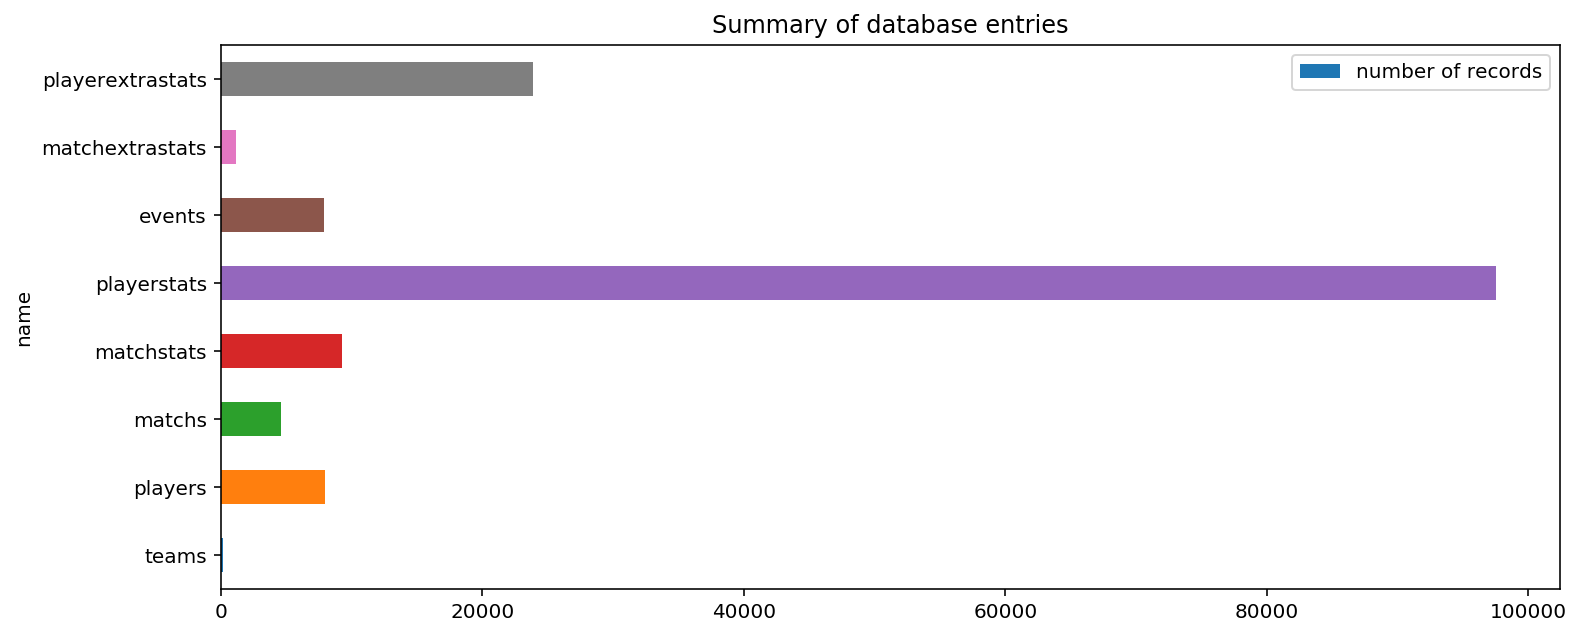

In [7]:
fig, ax = plt.subplots(figsize=(12,5))

tables.plot(y='count', kind='barh', ax = ax)
ax.set_title("Summary of database entries")
ax.legend(["number of records"])

### 2) The aims

- Create some visualisations highlighting game statistics aggregated at the player/team/year level in order to better grasp the dataset
- Use PCA and other non linear dimension reduction algorythms to get overall visualisations of the dataset, maybe a starting point for clustering, and find out how the information is structured : we aim at simplifying our data structures (especially the extra statistics) and keep only the meaningful variables.
- Do some clustering based on those principal components, at a position level and at a team level.
- Predict the winner of matches based on the principal component of each of the players and home or away.

### 3) Data charateristics

#### a) The types
As we've chosen to scrape the data ourselves, we had great latitude in defining the data types to store the data. Here's an excerpt of the *schema* of the tables that we'll use in our following analysis : 

In [8]:
def get_table_schema(table_name):
    schema = pd.read_sql_query("PRAGMA table_info({})".format(table_name), conn)
    return schema.drop(labels=["dflt_value", "pk", "cid"], axis=1)

for output in (get_table_schema(table) for table in tables.index.tolist()):
    display(output)

,name,type,notnull
0,id,INTEGER,1
1,name,VARCHAR(80),1


,name,type,notnull
0,id,INTEGER,1
1,name,VARCHAR(80),1
2,full_name,VARCHAR(160),0
3,birthday,DATETIME,0
4,height,FLOAT,0
5,weight,INTEGER,0


,name,type,notnull
0,id,INTEGER,1
1,home_team_id,INTEGER,1
2,away_team_id,INTEGER,1
3,ground_id,INTEGER,1
4,won,SMALLINT,1
5,match_type,SMALLINT,1
6,date,DATETIME,1


,name,type,notnull
0,id,INTEGER,1
1,match_id,INTEGER,1
2,team_id,INTEGER,1
3,scored,INTEGER,1
4,conceded,INTEGER,1
5,tries,INTEGER,0
6,cons,INTEGER,0
7,pens,INTEGER,0
8,drops,INTEGER,0


,name,type,notnull
0,id,INTEGER,1
1,player_id,INTEGER,1
2,team_id,INTEGER,1
3,match_id,INTEGER,1
4,position,VARCHAR(20),0
5,number,INTEGER,0
6,first_team,BOOLEAN,1
7,tries,INTEGER,0
8,cons,INTEGER,0
9,pens,INTEGER,0


,name,type,notnull
0,id,INTEGER,1
1,player_id,INTEGER,1
2,team_id,INTEGER,1
3,match_id,INTEGER,1
4,time,INTEGER,1
5,action_type,VARCHAR(5),1
6,extra_info,TEXT,0


,name,type,notnull
0,id,INTEGER,1
1,match_id,INTEGER,1
2,team_id,INTEGER,1
3,pens_attempt,INTEGER,0
4,pens_conceded,INTEGER,0
5,drops_attempt,INTEGER,0
6,kicks,INTEGER,0
7,passes,INTEGER,0
8,runs,INTEGER,0
9,meters,INTEGER,0


,name,type,notnull
0,id,INTEGER,1
1,player_id,INTEGER,1
2,team_id,INTEGER,1
3,match_id,INTEGER,1
4,tries,INTEGER,0
5,assists,INTEGER,0
6,points,INTEGER,0
7,kicks,INTEGER,0
8,passes,INTEGER,0
9,runs,INTEGER,0


However, data types in SQLite are much more limited that the ones Python (numpy) offers, especially when it comes to the encoding of numbers. As such, pandas `read_sql_query` function doesn't infer the correct level of number precision when reading the result of a query.

In [9]:
matchs_sample = pd.read_sql_query("SELECT * FROM matchs LIMIT 10", conn, parse_dates=["date"])
matchs_sample.dtypes

id                       int64
home_team_id             int64
away_team_id             int64
ground_id                int64
won                      int64
match_type               int64
date            datetime64[ns]
dtype: object

So here's a helper to cast specific columns to a specific type when needed. Most of the time, all columns will be numeric so we will just use `pd.to_numeric` to optimize the precision of the number type used for each column.
We also create another helper that takes care of the missing values that can appear in some SQL joins

In [10]:
# All helpers return a new instance of the dataframe to avoid overwriting base dataframes.
def cast_columns(df, type_tuples):
    processed_df = df.copy()
    if not isinstance(type_tuples, list):
        raise Exception("Types must be provided as a list")
        
    for (downcast, columns) in type_tuples:
        processed_df[columns] = processed_df[columns].apply(pd.to_numeric, errors='coerce', downcast=downcast)
    return processed_df

def cast_integer(df):
    processed_df = df.copy()
    
    # Get a list of the numeric columns of the dataframe
    numeric_columns = processed_df.select_dtypes(include=[np.number]).columns.tolist()
    # Fill the NA with 0 to allow the int conversion
    processed_df = processed_df.fillna(0)
    # Apply pd.to_numeric to every concerned column
    processed_df[numeric_columns] = processed_df[numeric_columns].apply(pd.to_numeric, errors='coerce', downcast='integer')
    return processed_df

In [11]:
matchs_sample_cast_1 = cast_columns(matchs_sample, type_tuples=[('integer', ["id", "home_team_id", "away_team_id"])])
matchs_sample_cast_2 = cast_integer(matchs_sample)

print(matchs_sample_cast_1.dtypes, matchs_sample_cast_2.dtypes)

id                       int16
home_team_id              int8
away_team_id              int8
ground_id                int64
won                      int64
match_type               int64
date            datetime64[ns]
dtype: object id                       int16
home_team_id              int8
away_team_id              int8
ground_id                int16
won                       int8
match_type                int8
date            datetime64[ns]
dtype: object


#### b) The relationships

The objects in the database maintain relations as follow:

- **Match**
    - has at most two **MatchStats** item
    - has at most one **MatchExtraStats** item
    - belongs at most to two **Team** items
    - has **Player** items
- **Player**
    - has at least one **PlayerStats** item
    - belongs to at least one **Match** item, through **PlayerStats**
    - has **PlayerExtraStats** items
- **Team**
    - has at least one **Match** item

### 4) Data consistency checking

#### a) Missing relations

During the scraping process, we discover that matchs didn't have the same data available depending on their media coverage, the context in which the match had been played (world cup ? exhibition ? test match ?), etc. As a result, we should provide an overview of the "completion" of the data before our analysis.

In [12]:
tables

,count
name,
teams,198
players,7971
matchs,4620
matchstats,9240
playerstats,97534
events,7923
matchextrastats,1136
playerextrastats,23862


First let's study the most basic relationship between the **Match** and **MatchStats** items. We want to see the number of matchs that have complete statistics.

In [13]:
# Check how many matchs have exactly 2 associated match stats
matchs_with_matchstats = pd.read_sql_query("""
    SELECT DISTINCT tmp.id
    FROM (SELECT M.id, COUNT(*) AS count
        FROM matchs AS M
        INNER JOIN matchstats AS MS ON M.id = MS.match_id
        GROUP BY M.id
        HAVING count = 2) as tmp""", conn)
ratio = matchs_with_matchstats.size / tables.loc["matchs", "count"]
print("Matchs with matchstats / Total matches : {:.2%}".format(ratio))

# Check how many matches have extended stats available
matchs_with_extra_stats = pd.read_sql_query("""SELECT DISTINCT MES.match_id FROM matchextrastats AS MES""", conn)
ratio = matchs_with_extra_stats.size / tables.loc["matchs", "count"]
print("Matchs with extended stats ({}) / Total matches : {:.2%}".format(matchs_with_extra_stats.size, ratio))

# Check how many matches have lineup info
matchs_with_player_info = pd.read_sql_query("""SELECT DISTINCT PS.match_id FROM playerstats AS PS""", conn)
ratio = matchs_with_player_info.size / tables.loc["matchs", "count"]
print("Matchs with player info / Total matches : {:.2%}".format(ratio))

# Check how many matches have player extended stats
matchs_with_player_extended_stats = pd.read_sql_query("""SELECT DISTINCT PES.match_id FROM playerextrastats AS PES""", conn)
ratio = matchs_with_player_extended_stats.size / tables.loc["matchs", "count"]
print("Matchs with player extended stats / Total matches : {:.2%}".format(ratio))

# Check how many matches have detailed event timings
matchs_with_events = pd.read_sql_query("""SELECT DISTINCT E.match_id FROM events AS E""", conn)
ratio = matchs_with_events.size / tables.loc["matchs", "count"]
print("Matchs with events ({}) / Total matches : {:.2%}".format(matchs_with_events.size, ratio))


Matchs with matchstats / Total matches : 100.00%
Matchs with extended stats (568) / Total matches : 12.29%
Matchs with player info / Total matches : 50.35%
Matchs with player extended stats / Total matches : 12.29%
Matchs with events (611) / Total matches : 13.23%


Here we observe that detailed data on players is only available for $12.29\%$ of the matchs, which nonetheless represents $568$ occurences. 
We are particularly interested in the number of matchs with events ($611$), as we are going to use this data to analyse the patterns of game events according to time. Here it seems that we have a fairly good number of matchs, even though the sparsity of the data is real.
Besides, when using joins in SQL, one missing value in a column forces pandas to convert the dtype of the column to float64 : in some cases, we will want to remove those missing rows from the dataset, in other cases we will prefer to fill the missing values with 0.

In [14]:
# Drop anomalies, i.e. matchstats without an associated match
cursor = conn.cursor()
cursor.execute("""DELETE FROM matchstats 
    WHERE match_id NOT IN 
        (SELECT DISTINCT M.id FROM matchs AS M)""")

try:
    conn.commit()
    print("Anomalies successfully deleted")
except Exception as e:
    print("Error : {}".format(e))

Anomalies successfully deleted


#### b) Outliers

We should also check for outliers that could have been inserted in the database as a result of a parsing error / source database inconsistency.
First, for the matchs scores and detailed stats :

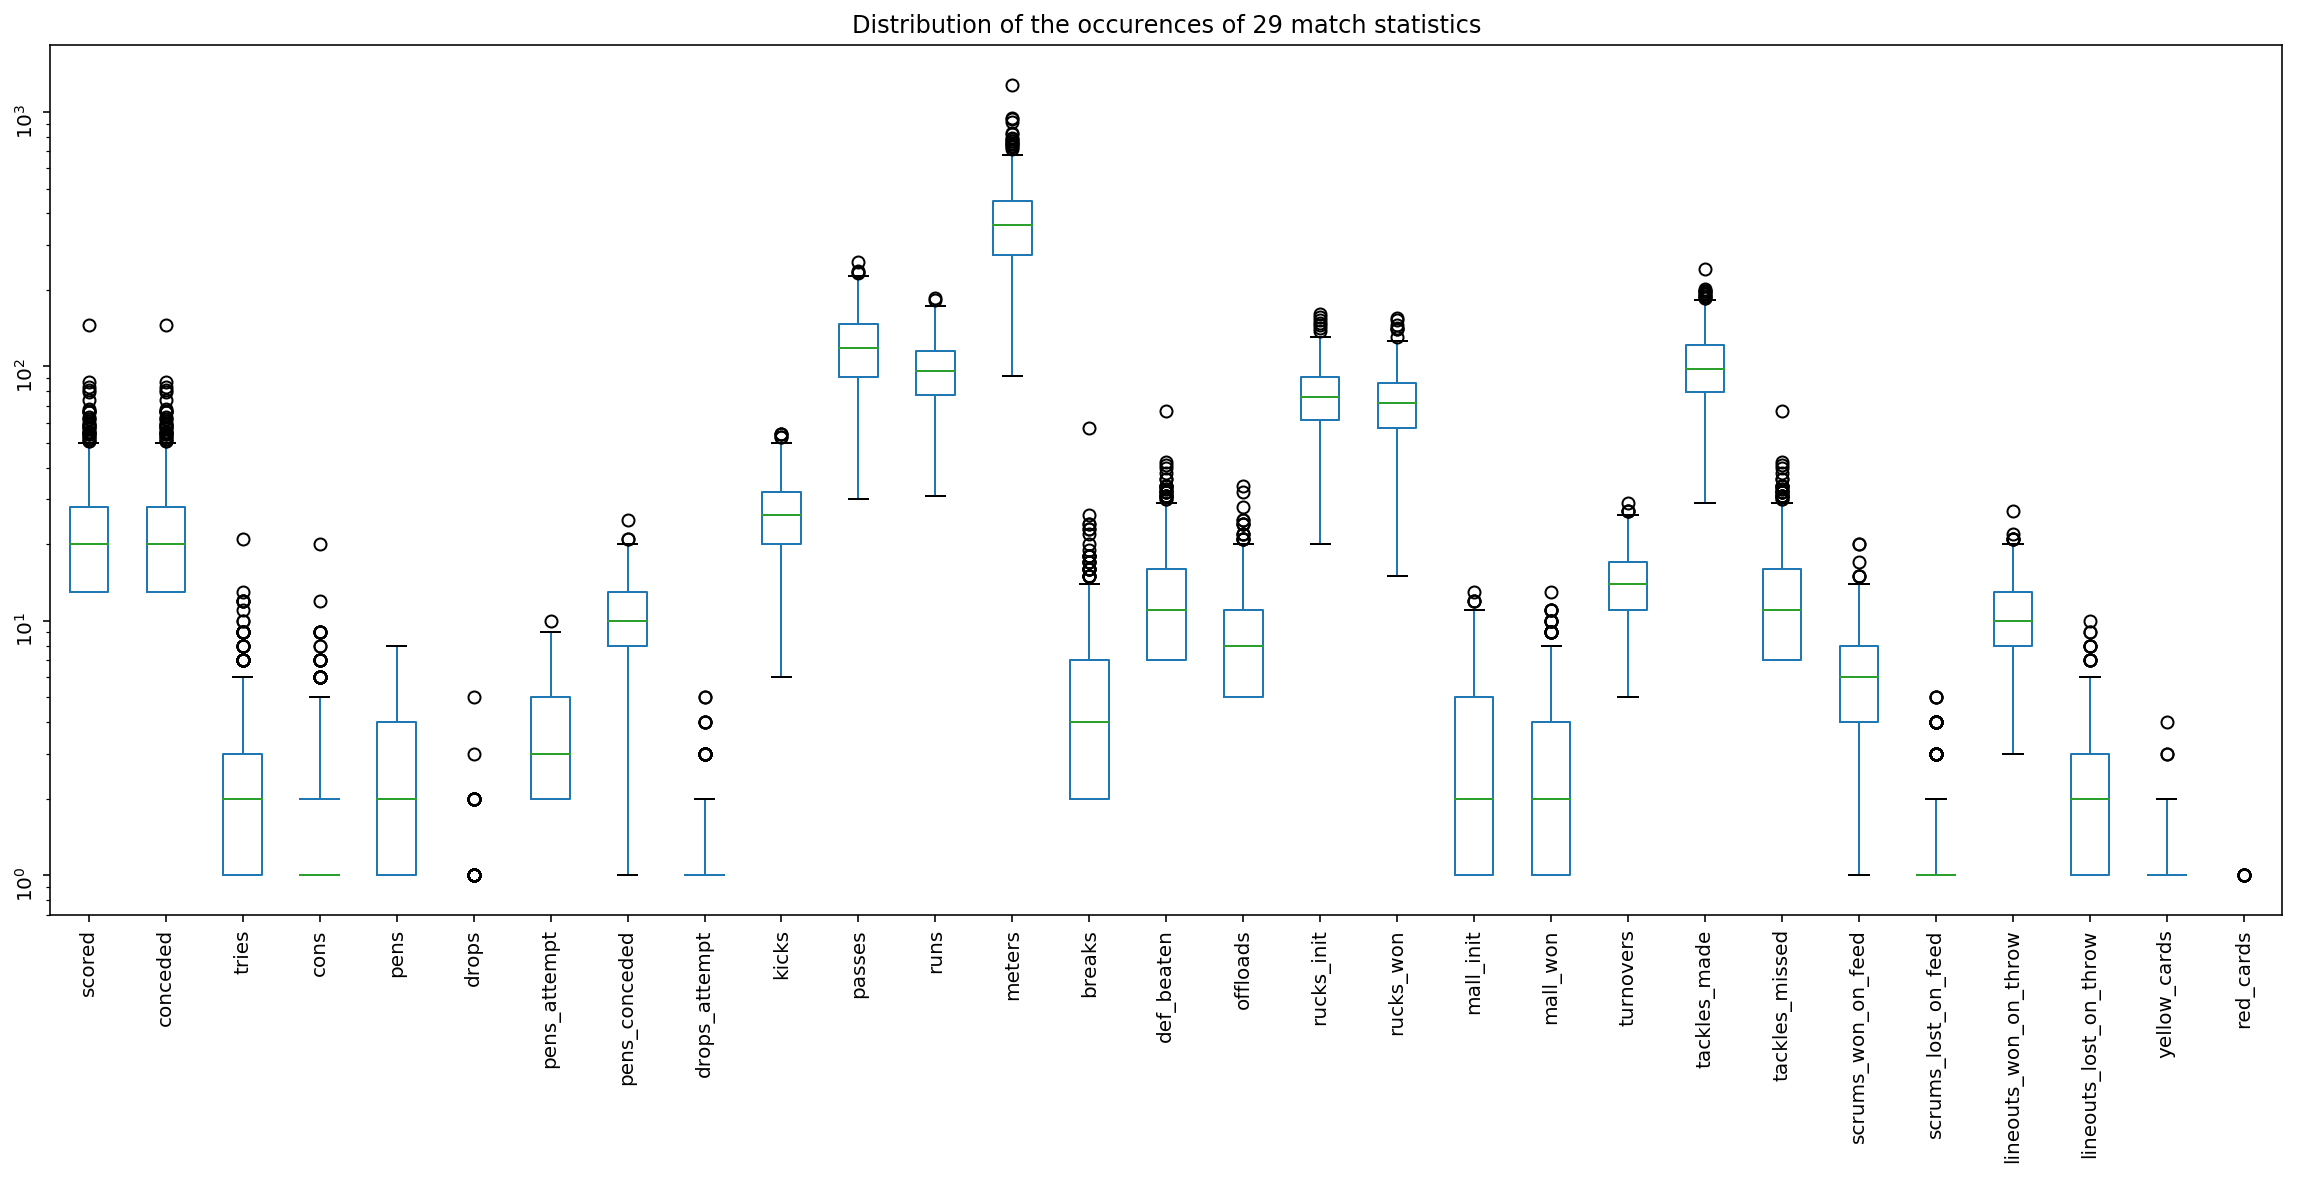

In [15]:
match_stats = pd.read_sql_query("""
    SELECT MS.*, MES.*
    FROM matchstats AS MS
    LEFT JOIN matchextrastats AS MES
        ON MS.match_id = MES.match_id AND MS.team_id = MES.team_id
""", conn)
# Drop non continuous variables and missing values
match_stats = match_stats.drop(["id", "match_id", "team_id"], axis=1).dropna()

# Plot boxplots
fig, ax = plt.subplots(figsize=(20,8))
match_stats.plot(kind="box", ax=ax)

ax.set_title("Distribution of the occurences of {} match statistics".format(len(match_stats.columns.tolist())))
ax.set_yscale("log")
ax.tick_params(rotation=90)

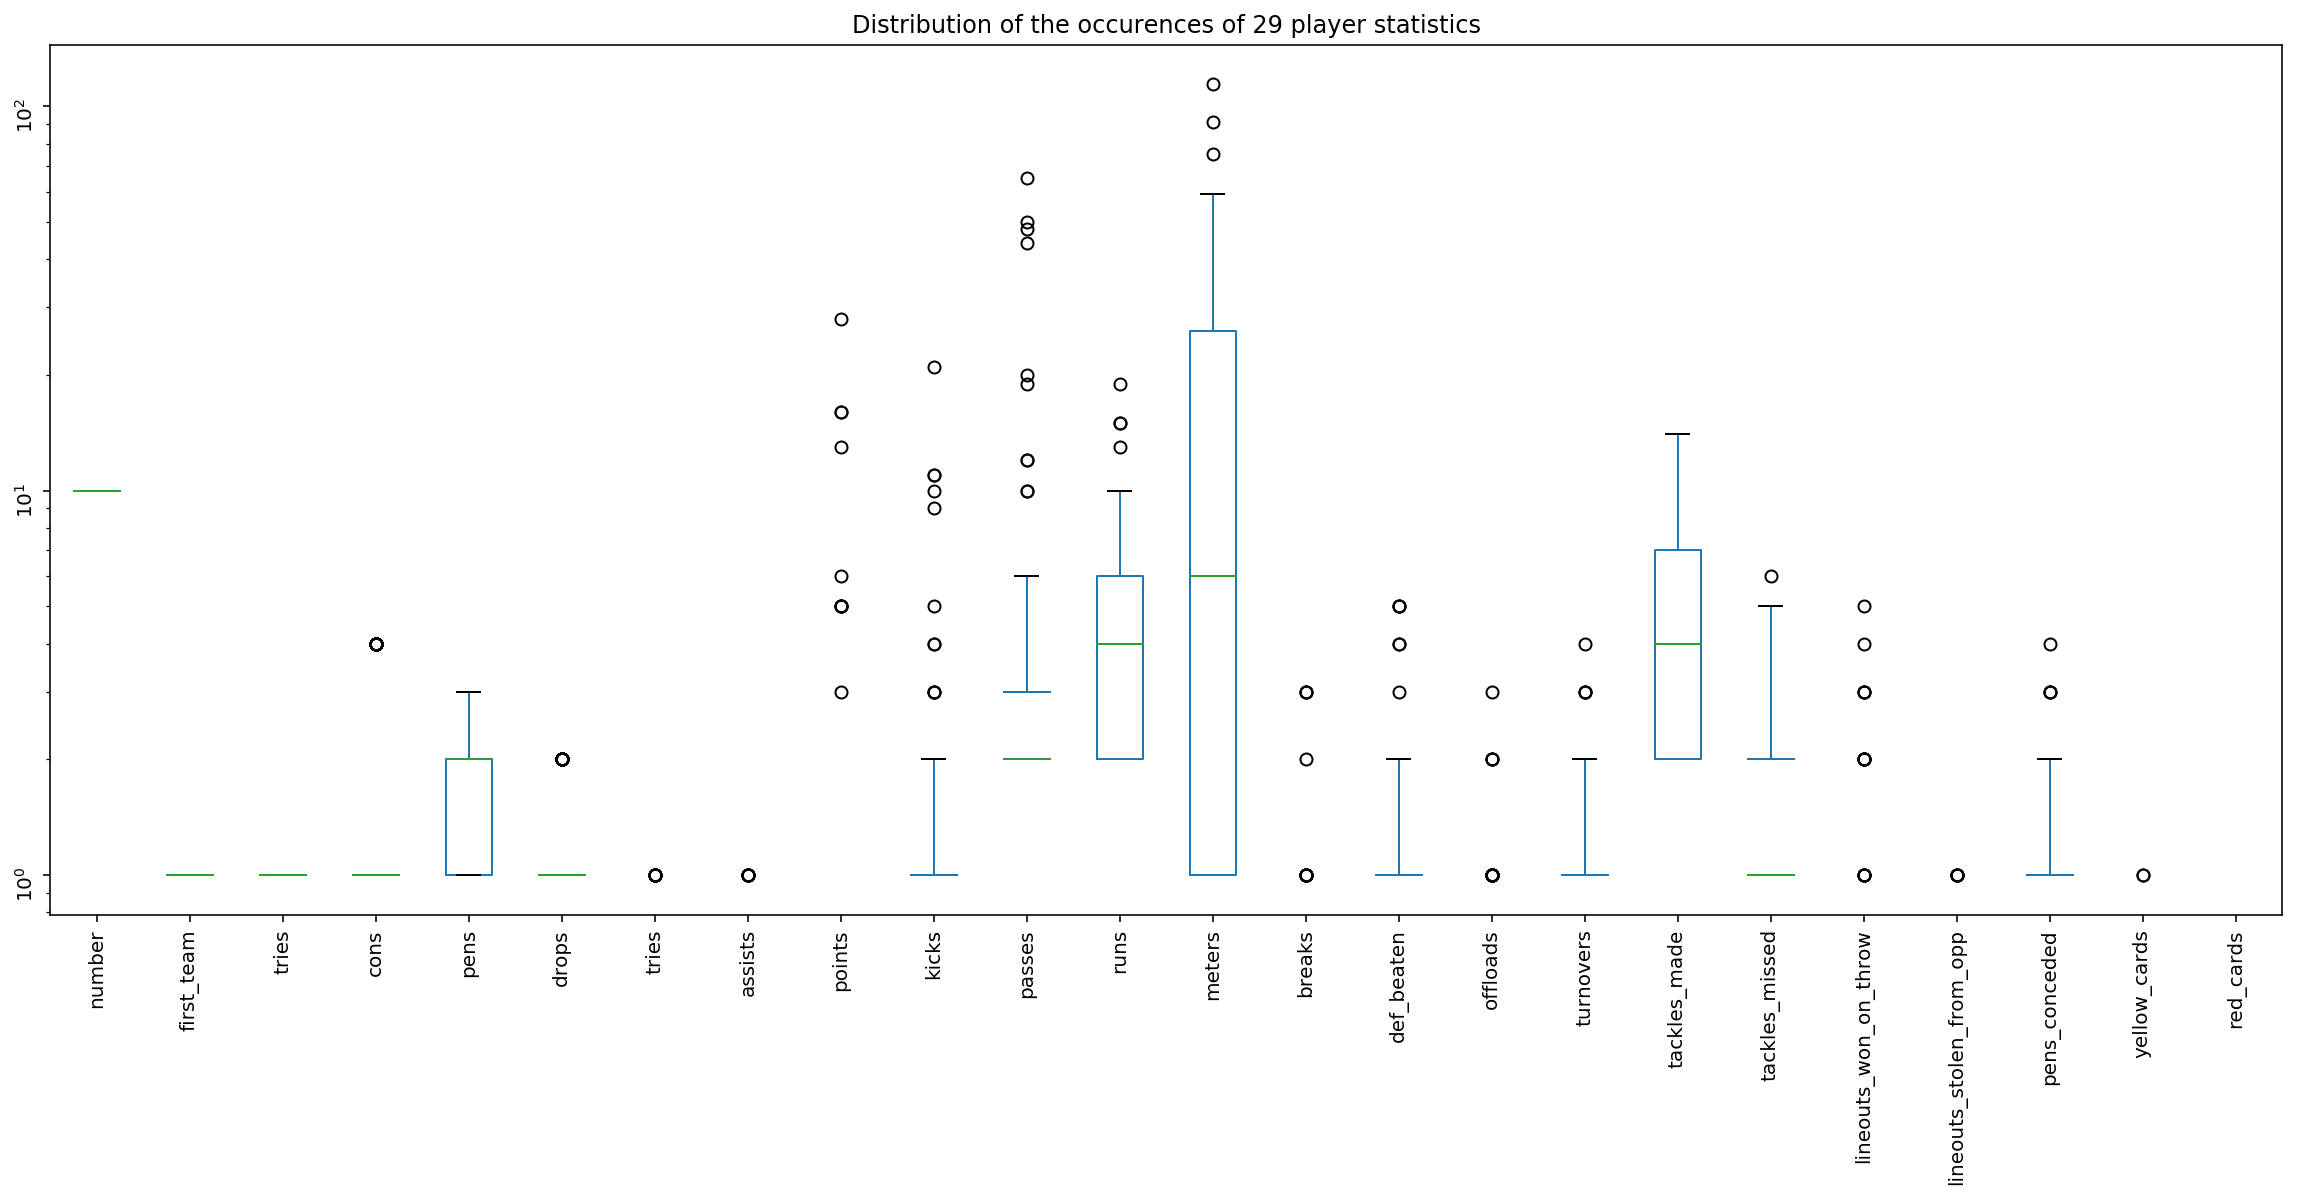

In [16]:
player_stats = pd.read_sql_query("""
    SELECT PS.*, PES.*
    FROM playerstats AS PS
    LEFT JOIN playerextrastats AS PES
        ON PS.match_id = PES.match_id AND PS.team_id = PES.team_id
""", conn)
# Drop non continuous variables and missing values
player_stats = player_stats.drop(["id", "player_id", "match_id", "team_id"], axis=1).dropna()

# Plot boxplots
fig, ax = plt.subplots(figsize=(20,8))
player_stats.plot(kind="box", ax=ax)

ax.set_title("Distribution of the occurences of {} player statistics".format(len(match_stats.columns.tolist())))
ax.set_yscale("log")
ax.tick_params(rotation=90)

### 5) Data visualisation and representation

#### Matchs

In [17]:
matchs = pd.read_sql_query("""
    SELECT M.id, M.match_type, M.date
    FROM matchs AS M
""", conn, parse_dates=["date"])

# Extract year and month from date
matchs['year'] = matchs.apply(lambda row: row['date'].year, axis=1)
matchs['month'] = matchs.apply(lambda row: row['date'].month, axis=1)
matchs = matchs.drop('date', axis=1)
matchs = cast_integer(matchs)
print(matchs.dtypes)

id            int32
match_type     int8
year          int16
month          int8
dtype: object


##### How many matchs have been played per year since 2000 ?

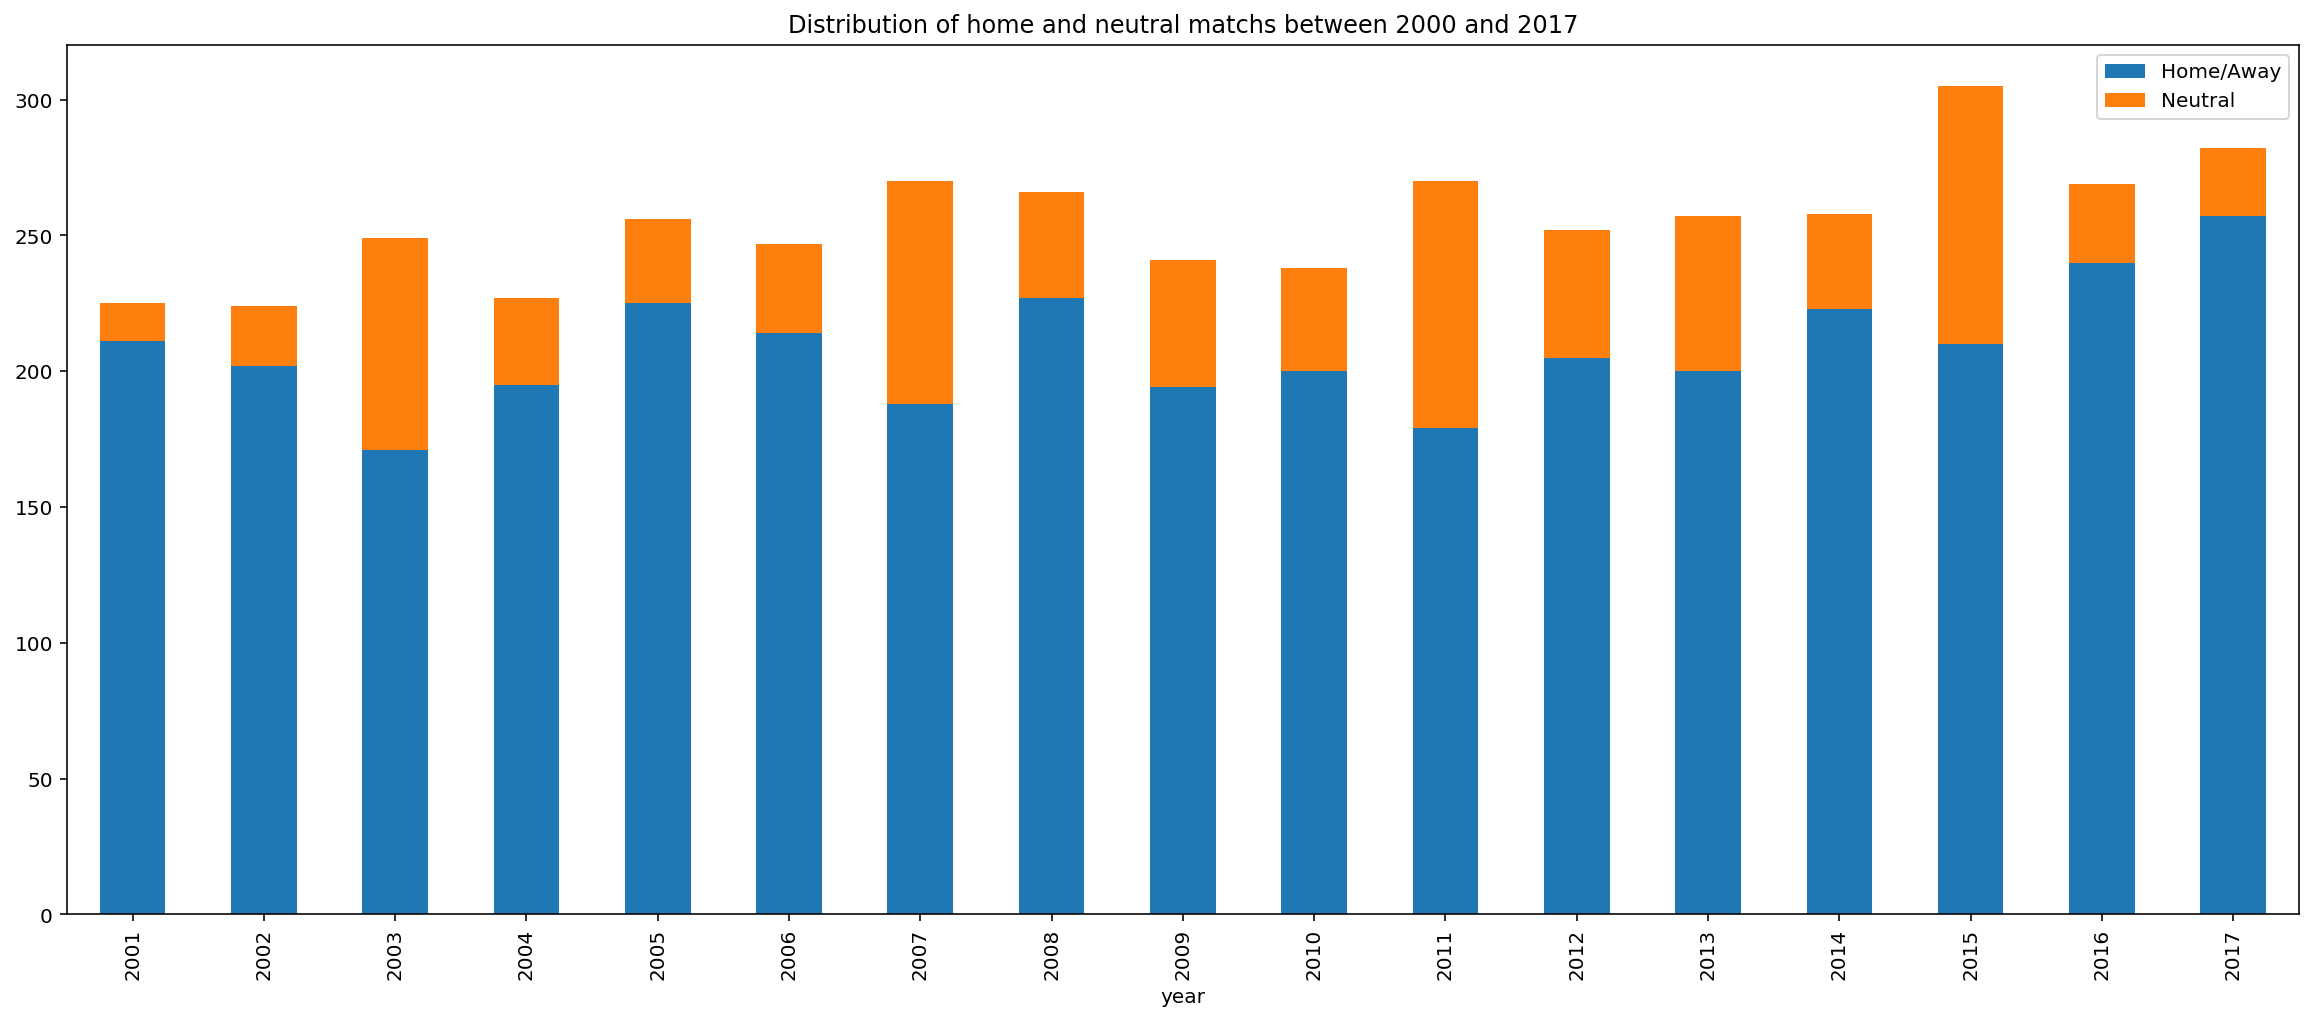

In [18]:
# Group data per year and filter match year > 2000
matchs_per_year = matchs.drop('month', axis=1).groupby(['year', 'match_type']).count()
matchs_per_year = matchs_per_year.loc[matchs_per_year.index.get_level_values('year') > 2000, :]

# Plot 
fig, ax = plt.subplots(figsize=(20,8))
matchs_per_year.unstack(level=1).plot(kind="bar", stacked=True, ax=ax)
ax.set_title("Distribution of home and neutral matchs between 2000 and 2017")
ax.legend(["Home/Away", "Neutral"], loc='best')

Here we see a significant increase in neutral games played during World Cup years, i.e 2003, 2007, 2011, 2015

##### What is the distribution of matchs in the year ?

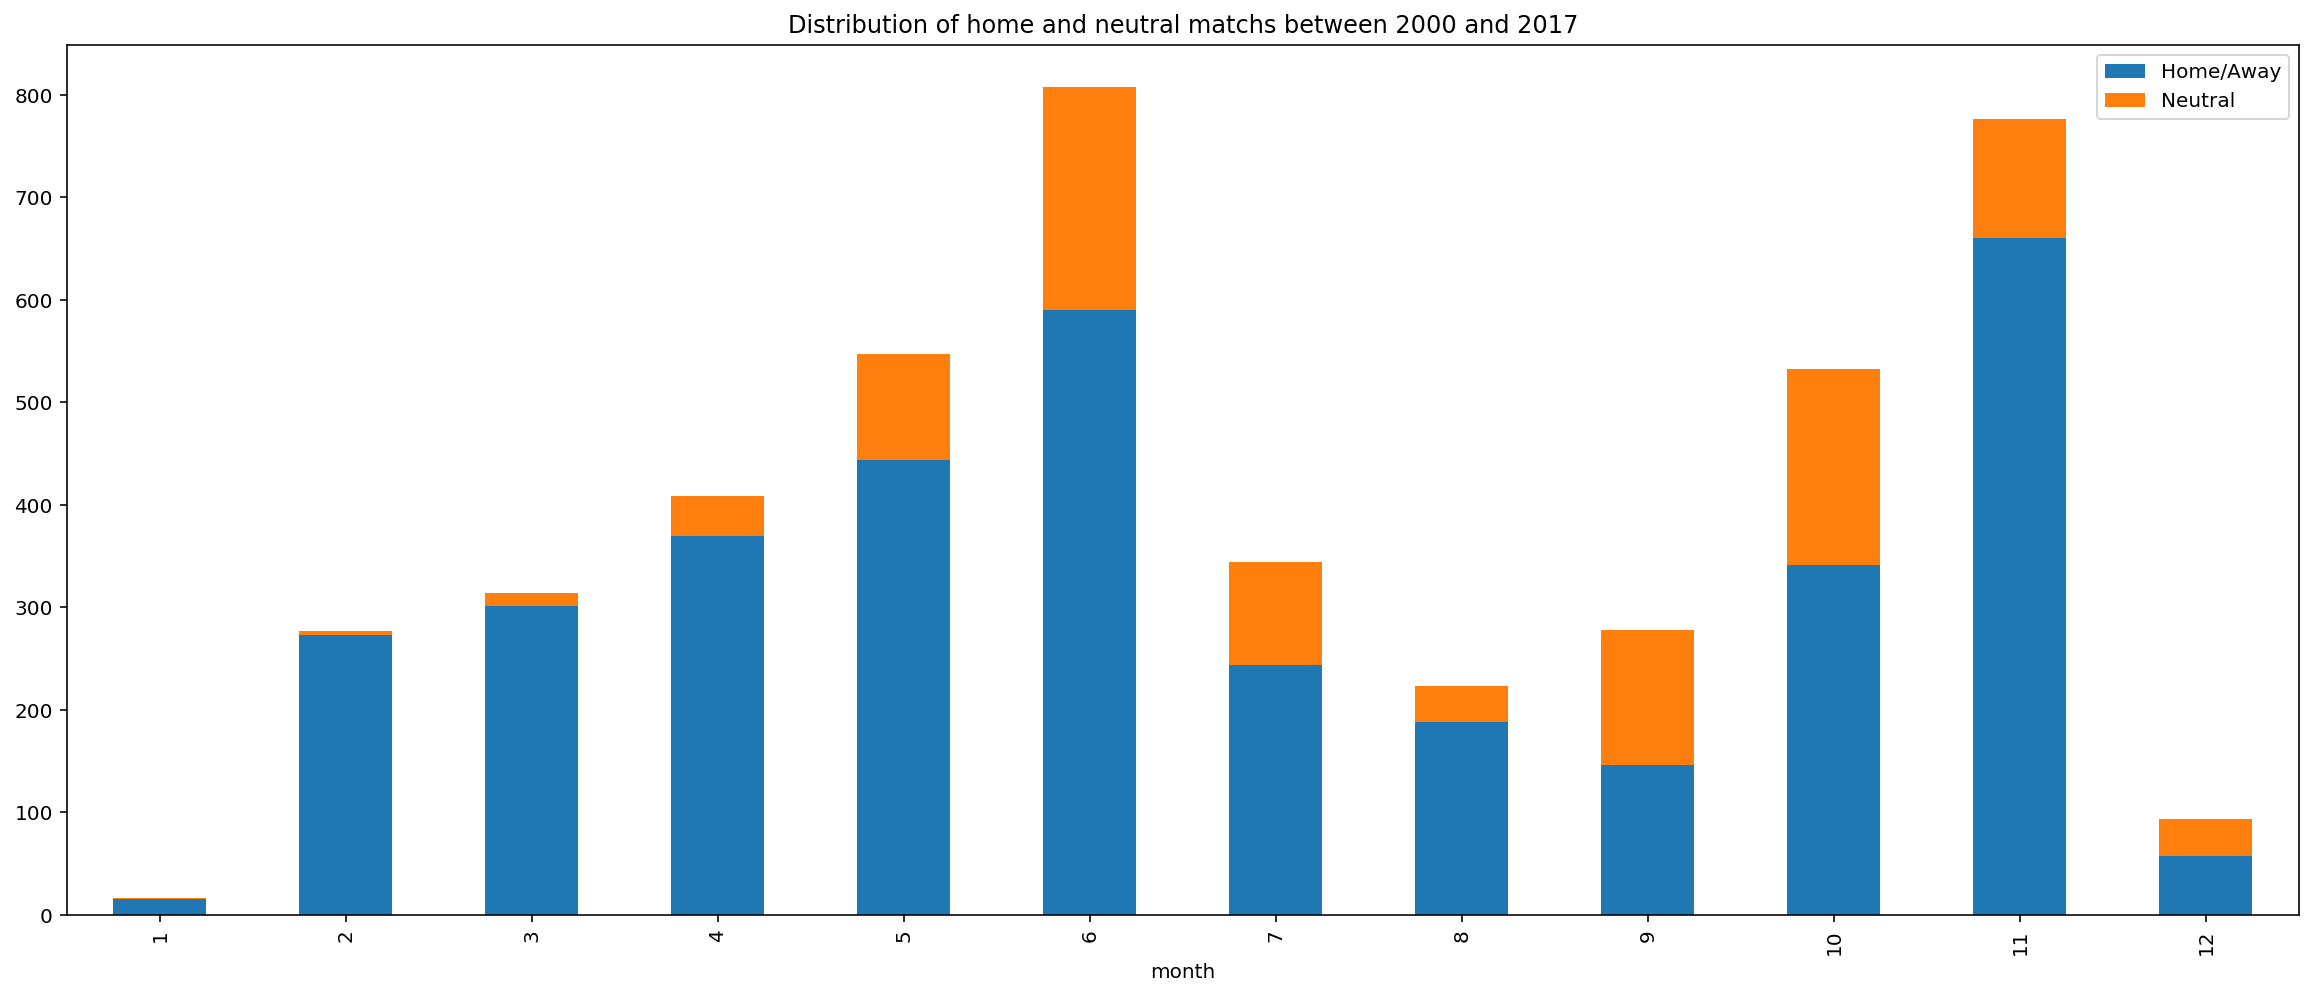

In [19]:
# Group data per month
matchs_per_year = matchs.drop('year', axis=1).groupby(['month', 'match_type']).count()

# Plot 
fig, ax = plt.subplots(figsize=(20,8))
matchs_per_year.unstack(level=1).plot(kind="bar", stacked=True, ax=ax)
ax.set_title("Distribution of home and neutral matchs between 2000 and 2017")
ax.legend(["Home/Away", "Neutral"], loc='best')

This graph highlights 3 major events happening each year :
- The test matchs, happening in June and November.
- The "Trination" cup between all major teams of the Southern hemisphere, in August/September.
- The "Six nations" cup between major European teams, in February/March

#### Teams

##### Which teams play the most often ?

In [20]:
# Retrieve the data
matchs_per_team = pd.read_sql_query("""
    SELECT M.id, M.team_id, T1.name AS team, T2.name AS opponent, MS.scored, M.date
    FROM (SELECT M1.id, M1.home_team_id AS team_id, M1.away_team_id AS opponent_id, M1.date
        FROM matchs AS M1
        UNION
        SELECT M2.id, M2.away_team_id AS team_id, M2.home_team_id AS opponent_id, M2.date
        FROM matchs AS M2) AS M
    LEFT JOIN teams AS T1 ON T1.id = M.team_id
    LEFT JOIN teams AS T2 ON T2.id = M.opponent_id
    LEFT JOIN matchstats AS MS ON (M.id = MS.match_id AND M.team_id = MS.team_id)
    ORDER BY M.date ASC
""", conn, parse_dates=["date"])

matchs_per_team["year"] = matchs_per_team["date"].apply(lambda x: x.year)

matchs_per_team_per_year = matchs_per_team.groupby(["year", "team"]).count()\
                            .drop(["id", "team_id", "opponent", "date"], axis=1)\
                            .rename(columns={"scored": "count"})\
                            .sort_values(by="count", ascending=False)

,count
year,
1992,"(1992, Chinese Taipei)"
1993,"(1993, Spain)"
1994,"(1994, Korea)"
1995,"(1995, France)"
1996,"(1996, Korea)"
1997,"(1997, Singapore)"
1998,"(1998, Chinese Taipei)"
1999,"(1999, South Africa)"
2000,"(2000, South Africa)"


/usr/local/lib/python3.6/site-packages/pandas/plotting/_core.py:1729: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



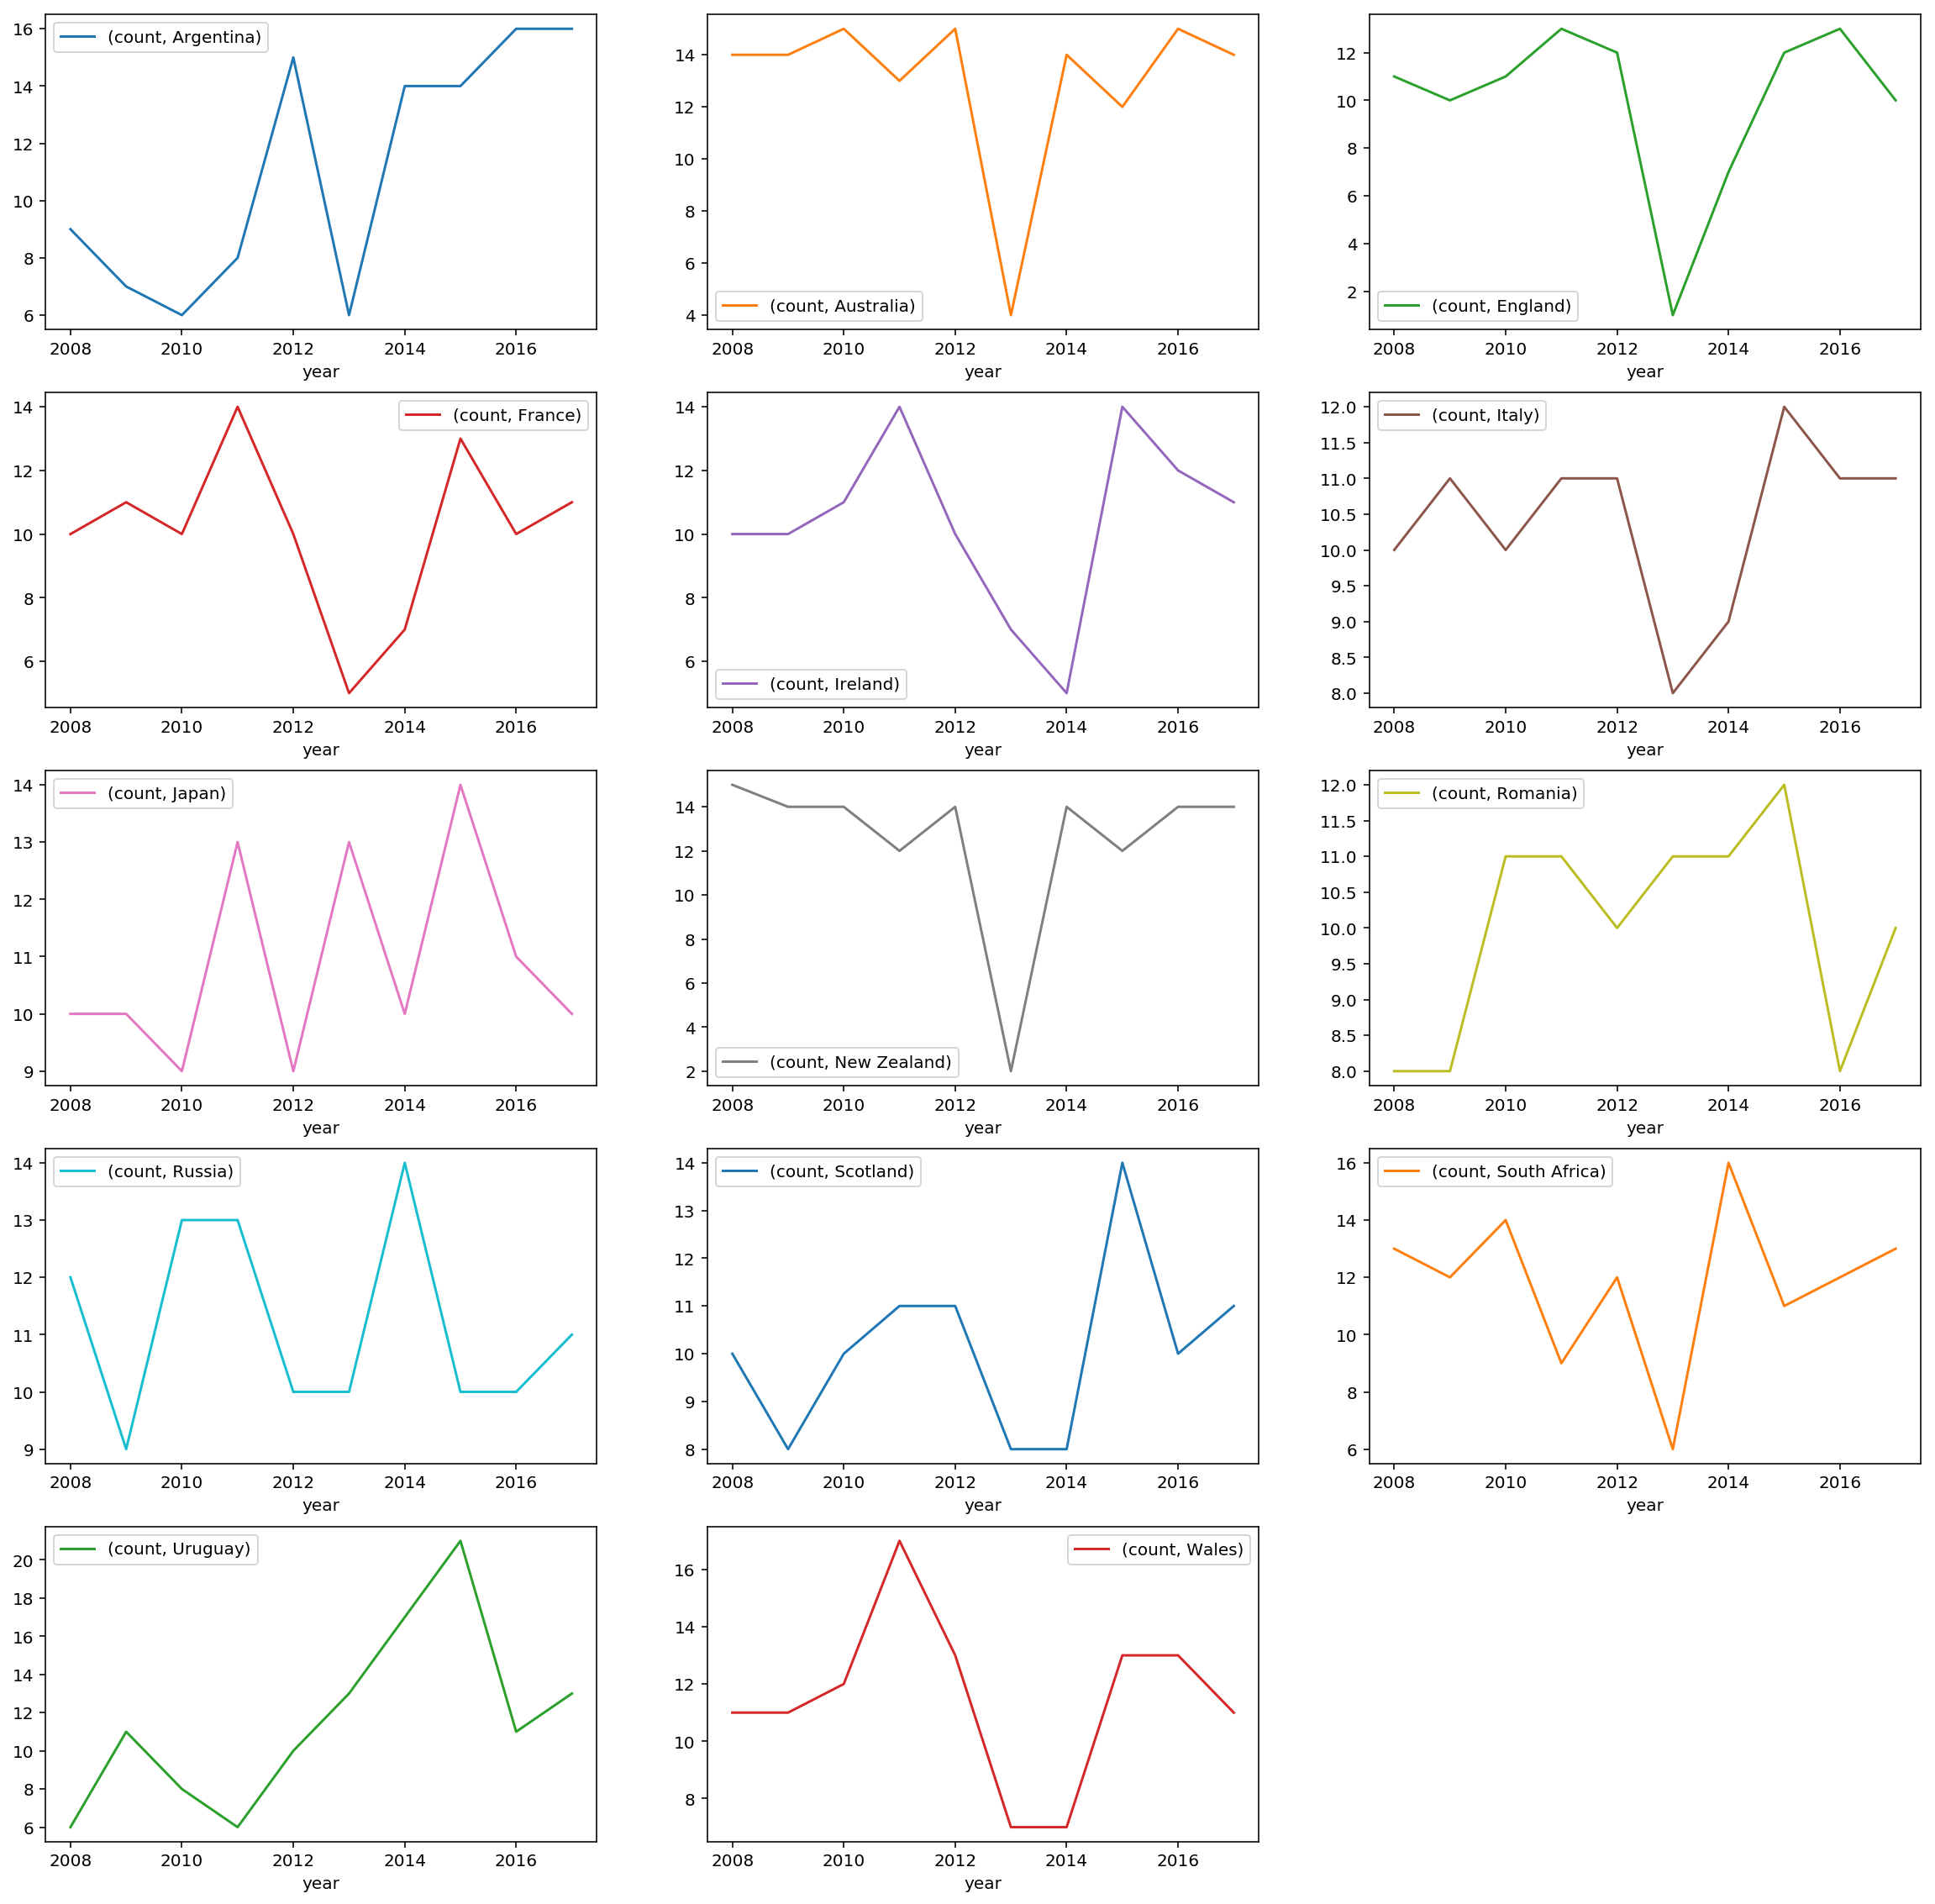

In [21]:
# Find out the team that played the most per year
data = matchs_per_team_per_year
display(data.groupby('year').idxmax(axis=0))

# Manipulate it to extract the top 10 teams that play the most often
data = matchs_per_team_per_year.unstack()
data = data.loc[data.index > 2007].dropna(axis=1).loc[:, data.mean() > 8]

fig, ax = plt.subplots(figsize=(20, 20))
data.plot(kind="line", ax=ax, stacked=True, subplots=True, layout=(5, 3))
ax.set_title("Distribution of the number of matchs played between 2008 and 2017 for the top 10 teams")
ax.legend(loc='best')

##### PCA

In [22]:
team_stats = pd.read_sql_query("""
SELECT 
    T.name, 
    AVG(pens_attempt) as pens_attempt,
    AVG(pens_conceded) as pens_conceded, 
    AVG(drops_attempt) as drops_attempt,
    AVG(kicks) as kicks, 
    AVG(passes) as passes,
    AVG(runs) as runs,
    AVG(meters) as meters, 
    AVG(breaks) as breacks, 
    AVG(def_beaten) as def_beaten, 
    AVG(offloads) as offloads,
    AVG(rucks_init) as rucks_init,
    AVG(rucks_won) as rucks_won,
    AVG(turnovers) as turnovers,
    AVG(tackles_made) as tackles_made,
    AVG(tackles_missed) as tackles_missed,
    AVG(scrums_won_on_feed) as scrums_won_on_feed, 
    AVG(scrums_lost_on_feed) as scrums_lost_on_feed,
    AVG(lineouts_won_on_throw) as lineouts_won_on_throw, 
    AVG(lineouts_lost_on_throw) as lineouts_lost_on_throw, 
    AVG(yellow_cards) as yellow_cards,
    AVG(red_cards) as red_cards
FROM matchextrastats MS 
INNER JOIN teams as T ON t.id = MS.team_id
GROUP BY team_id
HAVING COUNT(MS.id) > 5
""", conn)

In [23]:
team_stats.describe()

,pens_attempt,pens_conceded,drops_attempt,kicks,passes,runs,meters,breacks,def_beaten,offloads,...,rucks_won,turnovers,tackles_made,tackles_missed,scrums_won_on_feed,scrums_lost_on_feed,lineouts_won_on_throw,lineouts_lost_on_throw,yellow_cards,red_cards
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,3.124776,10.530391,0.341627,24.915089,118.738539,98.618529,359.443240,5.217957,14.023689,8.286266,...,72.143283,14.085704,105.039214,16.675429,6.466325,1.012942,10.216385,2.118090,0.462426,0.024820
std,0.676835,1.198119,0.202634,2.518774,18.200304,10.761486,58.541745,1.438737,2.967855,1.937845,...,9.491889,1.000538,9.828414,5.291208,0.666996,0.383242,0.826631,0.474791,0.206581,0.033980
min,1.375000,9.096154,0.000000,21.238095,80.625000,65.500000,226.428571,2.571429,7.928571,5.636364,...,43.750000,12.311828,81.388889,11.965517,5.181818,0.482759,9.000000,1.355556,0.227273,0.000000
25%,2.811756,9.747753,0.210283,23.553995,112.108806,92.940283,334.630981,4.586957,12.490209,6.909341,...,68.780870,13.309732,99.427573,12.587518,6.067857,0.779762,9.546875,1.830731,0.354885,0.000000
50%,3.334028,10.062500,0.327957,24.736607,120.101852,100.431818,371.564559,5.238095,14.732828,8.162026,...,71.850168,14.029944,107.663659,15.929487,6.444444,0.899935,10.219044,2.023810,0.397162,0.011966
75%,3.602778,11.276018,0.445225,26.092092,131.839548,105.274215,385.027778,6.023705,15.694664,9.888889,...,78.547497,14.897727,111.884375,17.832880,7.107356,1.165459,10.679041,2.447690,0.512987,0.027915
max,3.954545,13.250000,0.704762,30.166667,145.142857,110.161290,484.750000,9.301724,18.482759,11.172414,...,88.408602,15.913043,116.298077,33.000000,7.474138,2.250000,11.742857,3.125000,1.000000,0.111111


Here we have a summary of data we have gathered on the different teams. The first thing to notice is the very small amount of data points. In fact we only have 20 teams for which we have relevant data (more than 5 matches to gather datra from). 
As for the data itself, we can see that it is pretty relevant as we cannot identify abberant values with regards to the quantiles. 
The  only values that appear to be quite far from the rest of the data are the max values for "tackles missed", "scrums_lost_on_feed" and "yellow_cards" which reflect a really bad team. However, those values all came from the same team (namibia) which is not known for its quality rugby.

In [24]:
# Computing PCA on 3 principal components
teams_pca = PCA(3)
std_team_stats = standardize(team_stats.drop("name", axis = 1))
teams_pca.fit(std_team_stats, verbuous=True )

new components : 

[[-0.19025909 -0.14940275  0.2043585 ]
 [ 0.18617936  0.13386522  0.01238942]
 [ 0.02066073 -0.34320434  0.28306308]
 [-0.0185761  -0.38169014  0.31613978]
 [-0.30395814  0.04951166 -0.08657447]
 [-0.32343396  0.10569306 -0.07930978]
 [-0.27144452  0.14124394  0.28517715]
 [-0.26595406  0.0756352   0.21371901]
 [-0.21925495  0.33703412  0.04180484]
 [-0.14084378  0.23907852  0.3471619 ]
 [-0.31183727  0.03791077 -0.20196352]
 [-0.30847991  0.04929329 -0.21283735]
 [ 0.0760199   0.18817626  0.38398327]
 [ 0.03293571 -0.41325671 -0.01713457]
 [ 0.27039634  0.10560757 -0.1575959 ]
 [ 0.14674369  0.0669354   0.45718077]
 [ 0.24801465 -0.05373638  0.0719317 ]
 [-0.19056717 -0.34147232 -0.03696785]
 [ 0.24927877  0.17185681 -0.11193236]
 [ 0.25268421  0.17827901 -0.03071096]
 [ 0.03623504  0.28237909  0.16513551]]


 that explain 0.6979137381898758 of the variance : 

component 1 : variance ratio of 0.41111677112396666
component 2 : variance ratio of 0.1685340341276399
com

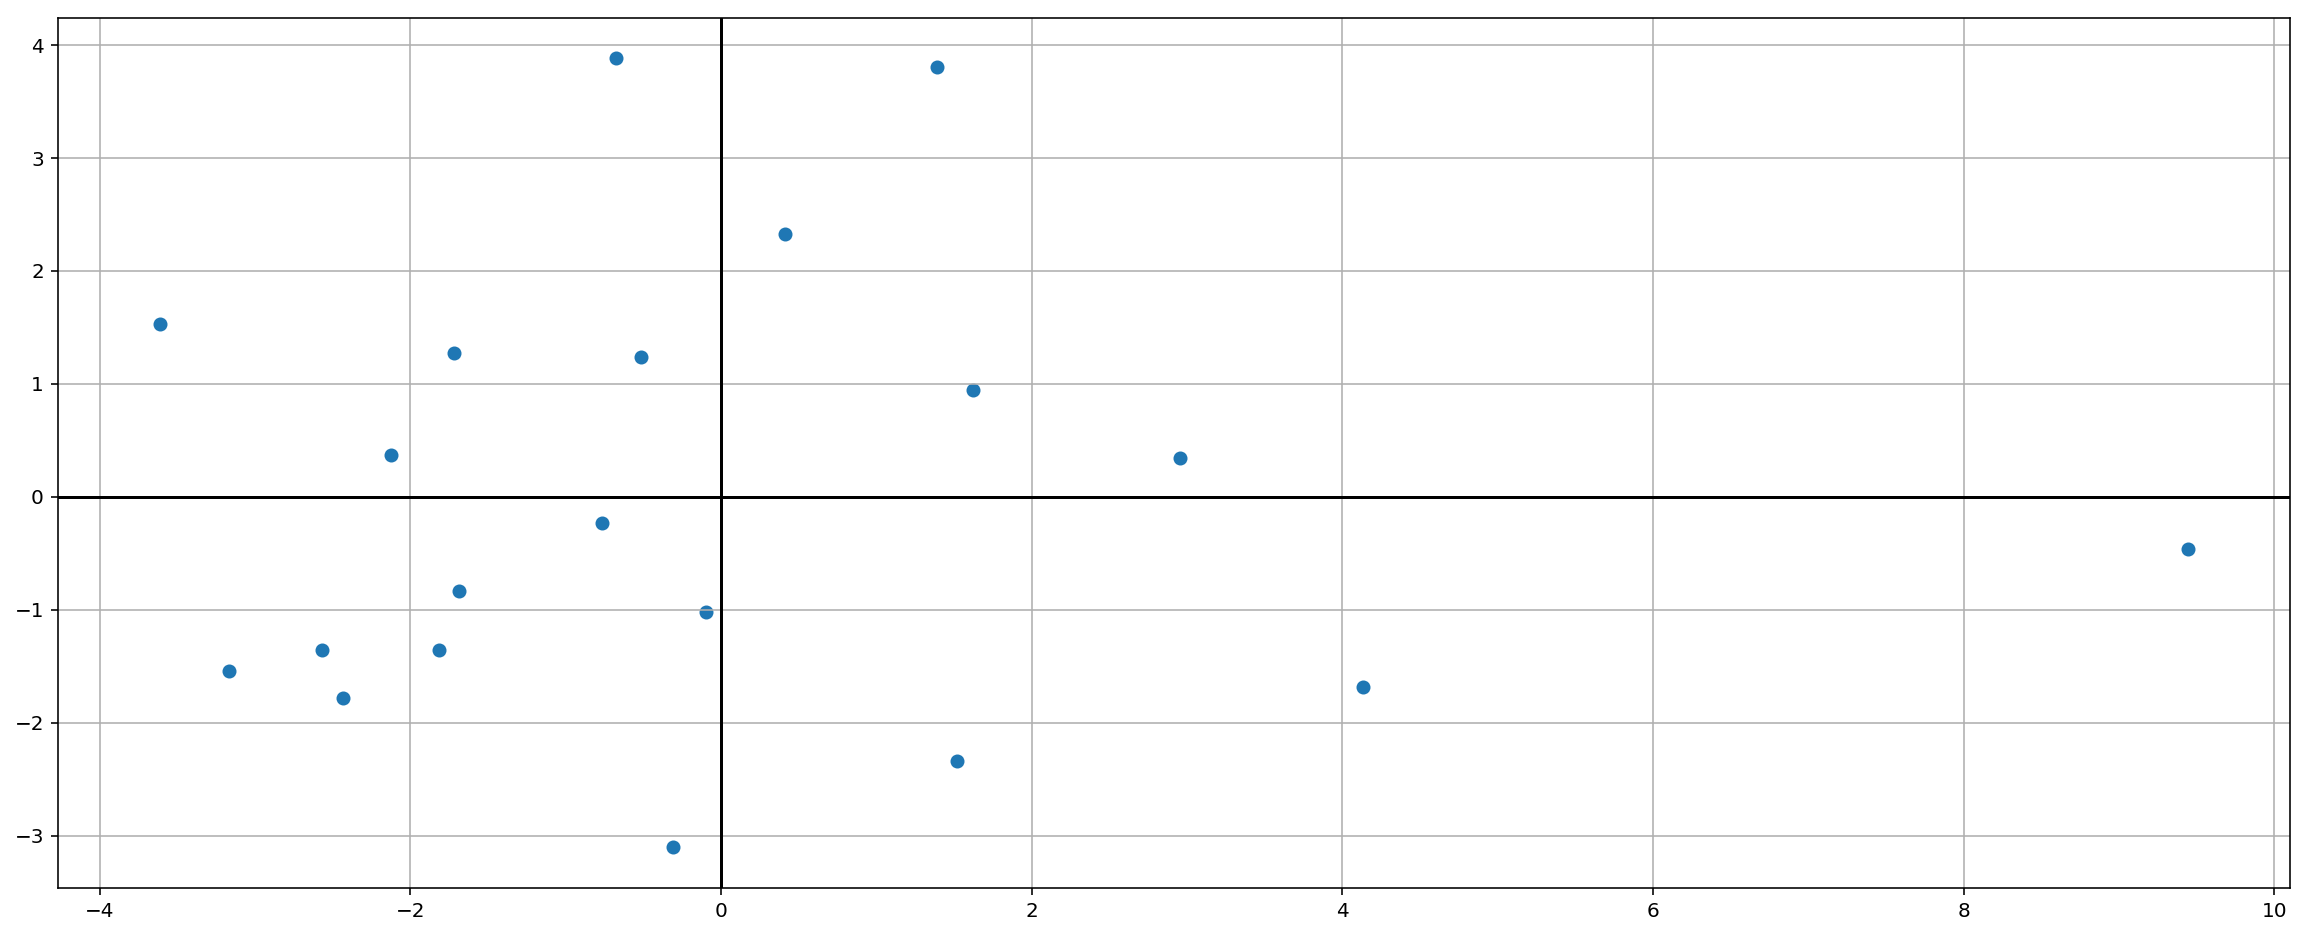

In [25]:
fig, ax = plt.subplots(figsize=(20,8))
ax.scatter(x=teams_pca.new_data[:,0], y=teams_pca.new_data[:,1])
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')

This graphical representation is not very helping as we do not have a lot of data points. Although trying a clustering on this data could teach us about the different types of game play in the rugby world, we believe we have too few points to achieve this consistently. 

#### Players

##### What is the distribution of average height/weight according to position ?

Full dataset : 7971 entries / Without NaN : 5260 entries


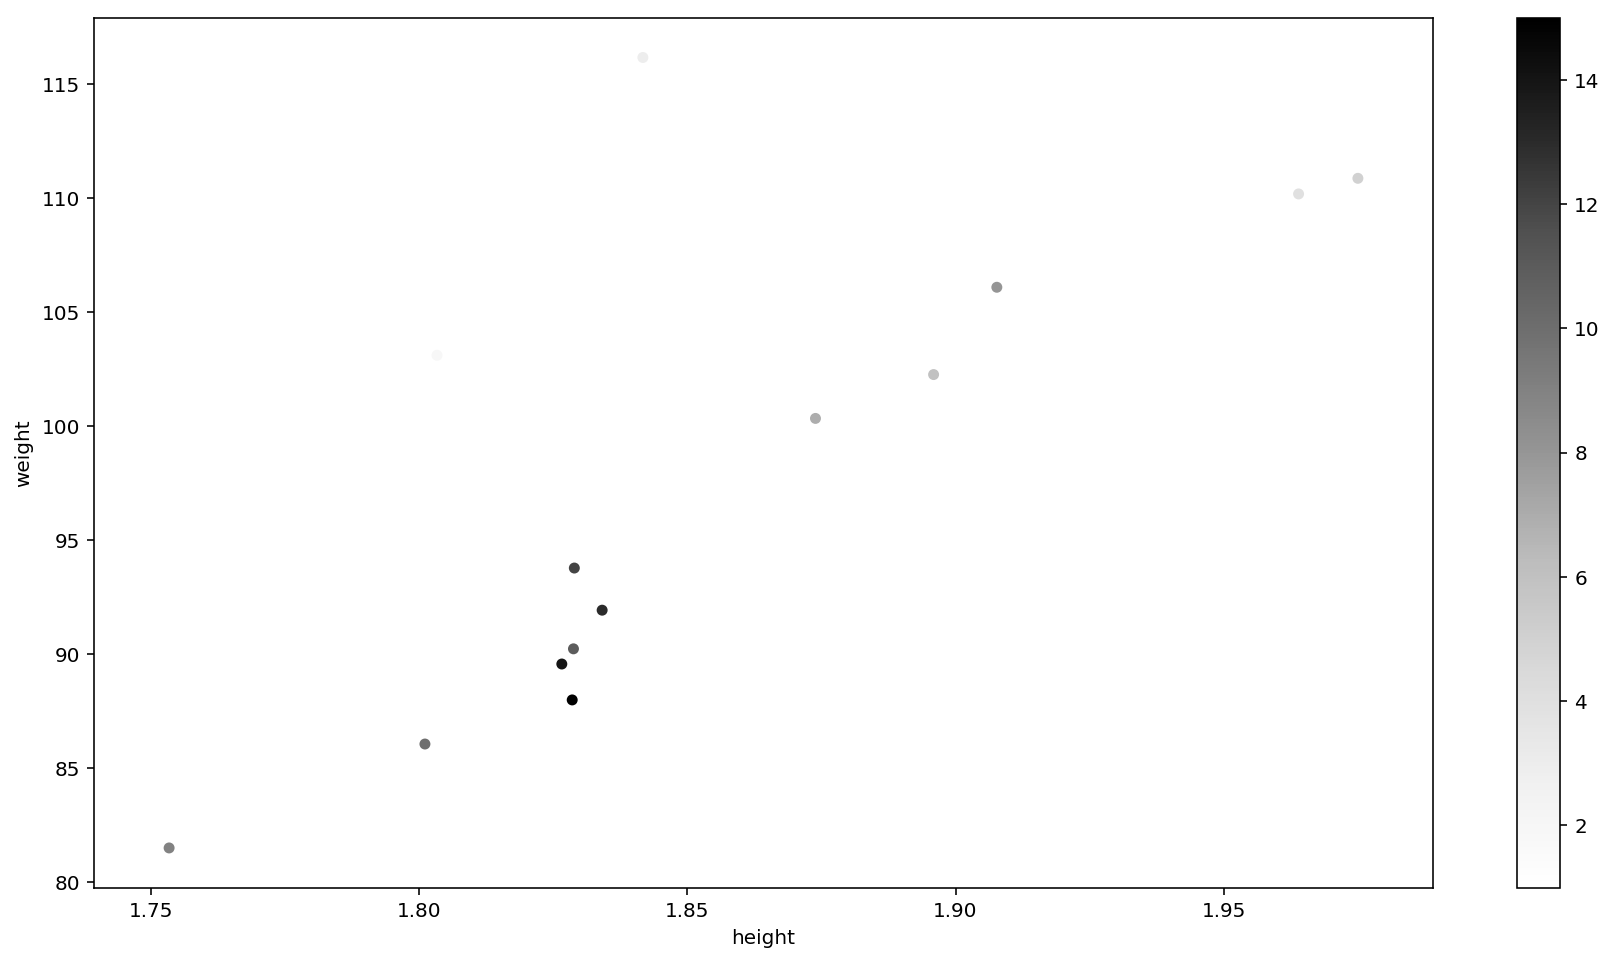

In [26]:
players = pd.read_sql_query("""
    SELECT P.id, P.name, POS.number AS most_common_number, P.height, P.weight
    FROM players as P
    LEFT JOIN 
        (SELECT tmp.player_id, tmp.number
        FROM
            (SELECT PS.player_id, PS.number, COUNT(*) as pos_count
            FROM playerstats AS PS
            GROUP BY PS.player_id, PS.number
            HAVING PS.number > 0 and PS.number <= 15) as tmp
        GROUP BY tmp.player_id
        HAVING tmp.pos_count = MAX(tmp.pos_count)) as POS
        ON POS.player_id = P.id
""", conn)

players_cleaned = cast_integer(players.dropna())
print("Full dataset : {:d} entries / Without NaN : {:d} entries".format(players.shape[0], players_cleaned.shape[0]))

# Aggregate per player and average height/weight
players_cleaned = players_cleaned.drop(["id", "name"], axis=1).groupby(["most_common_number"]).agg(np.mean)

# Plot
fig, ax = plt.subplots(figsize=(15,8))
players_cleaned.plot(x='height', y='weight', kind="scatter", ax=ax, c=players_cleaned.index, colorbar=True)

##### PCA 

In [27]:
player_stats = pd.read_sql_query("""
SELECT 
    P.name, 
    P.weight,
    P.height,
    temp2.number,
    AVG(tries) as tries, 
    AVG(assists) as assists, 
    AVG(points) as points,
    AVG(kicks) as kicks,
    AVG(passes) as passes,
    AVG(runs) as runs,
    AVG(meters) as meters,
    AVG(breaks) as breaks,
    AVG(def_beaten) as def_beaten, 
    AVG(offloads) as offloads,
    AVG(turnovers) as turnovers, 
    AVG(tackles_made) as tackles_made,
    AVG(tackles_missed) as tackles_missed,
    AVG(lineouts_won_on_throw) as lineouts_won_on_throw, 
    AVG(lineouts_stolen_from_opp) as lineouts_stolen_from_opp,
    AVG(pens_conceded) as pens_conceded,
    AVG(yellow_cards) as yellow_cards,
    AVG(red_cards) as red_cards
FROM playerextrastats PES
INNER JOIN players as P ON P.id = PES.player_id
LEFT JOIN 
        (SELECT temp.number, temp.player_id
        FROM 
            (SELECT P.number, COUNT(P.player_id) as count, P.player_id
            FROM playerstats as P 
            GROUP BY P.player_id, P.number) as temp
        GROUP BY player_id
        HAVING MAX(temp.count)) as temp2 
    ON temp2.player_id = PES.player_id
WHERE temp2.number < 16  
GROUP BY PES.player_id
HAVING COUNT(PES.id) > 5
""", conn)

In [28]:
player_stats.describe()

,weight,height,number,tries,assists,points,kicks,passes,runs,meters,...,def_beaten,offloads,turnovers,tackles_made,tackles_missed,lineouts_won_on_throw,lineouts_stolen_from_opp,pens_conceded,yellow_cards,red_cards
count,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000,...,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000
mean,102.423377,1.871701,8.138961,0.114045,0.074097,1.085456,1.208097,5.478897,5.094342,19.798194,...,0.762565,0.424150,0.700882,5.188499,0.754465,0.503000,0.051542,0.478245,0.018282,0.001158
std,12.445668,0.074611,4.242048,0.147454,0.105281,1.902734,2.115667,9.622234,2.257332,16.755887,...,0.746320,0.355933,0.396678,2.350091,0.441715,0.851693,0.106007,0.315728,0.035889,0.009162
min,71.000000,1.650000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.545455,0.000000,...,0.000000,0.000000,0.000000,0.785714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,93.000000,1.830000,5.000000,0.000000,0.000000,0.000000,0.000000,1.222222,3.444444,6.965116,...,0.200000,0.166667,0.411765,3.375000,0.461538,0.000000,0.000000,0.250000,0.000000,0.000000
50%,102.000000,1.850000,8.000000,0.069767,0.027047,0.449495,0.142857,2.205263,4.777778,14.233766,...,0.509619,0.333333,0.648529,4.940351,0.666667,0.080816,0.000000,0.428571,0.000000,0.000000
75%,112.750000,1.930000,12.000000,0.166667,0.111111,1.166667,1.396154,4.250000,6.421429,27.306818,...,1.148214,0.587916,0.957880,6.531814,1.000000,0.612455,0.055556,0.646008,0.025316,0.000000
max,136.000000,2.110000,15.000000,1.100000,0.625000,13.982759,13.571429,66.274510,15.625000,94.222222,...,4.333333,2.722222,2.500000,15.166667,3.625000,4.881356,0.728814,1.826087,0.285714,0.125000


Here we see a data set that looks more inconsistent than the teams one at first glance as somme statistics appear to have outliers. For instance the max number of points is more than 10 times higher than the 3 quartile. However these dicrepencies in the data can be explained by the really different role of players in a rugby game according to their position. For instance there are usually only one or two players that attempts penalties for the hole team and it is not unreasonable to believe that those players could score around 10 points per match. 

In [29]:
# Compute the PCA on 3 components
players_pca = PCA(3)
std_player_stats = standardize(player_stats.drop(["name", "number"], axis = 1))
players_pca.fit(std_player_stats , verbuous=True )

new components : 

[[-0.27389751 -0.24571343  0.09256634]
 [-0.19338697 -0.35203572 -0.15723965]
 [ 0.27001747 -0.17750649  0.18473418]
 [ 0.25420804  0.05228331 -0.2702957 ]
 [ 0.22518407  0.1195413  -0.25069332]
 [ 0.2271012   0.26200507 -0.3850959 ]
 [ 0.14525734  0.27217772 -0.39554661]
 [ 0.20146078 -0.39872004 -0.04005542]
 [ 0.33512426 -0.23252013  0.13776019]
 [ 0.32047082 -0.19011105  0.15693102]
 [ 0.31368211 -0.24231013  0.13042186]
 [ 0.23388558 -0.21732043 -0.10450128]
 [ 0.27408016 -0.16912323 -0.1834474 ]
 [-0.17039756 -0.24978961 -0.25784363]
 [ 0.08824219 -0.05963629 -0.20895478]
 [-0.18901479 -0.29001958 -0.35409479]
 [-0.16793495 -0.252566   -0.37863181]
 [-0.20400436 -0.146311   -0.01897604]
 [-0.02157465 -0.04839476 -0.04399742]
 [-0.00433992 -0.05571712  0.06275446]]


 that explain 0.5536247514158538 of the variance : 

component 1 : variance ratio of 0.3110412781731999
component 2 : variance ratio of 0.153083338007397
component 3 : variance ratio of 0.0895001352

In [30]:
# Plot with plotly to get interactive 3D representation
iplot([go.Scatter3d(
    x = players_pca.new_data[:,0],
    y = players_pca.new_data[:,1],
    z = players_pca.new_data[:,2],
    mode = 'markers',
     marker=dict(
         color = player_stats.loc[:,"number"].values,
         colorscale='Viridis',
         showscale = True,
        size=3)
)])

Here we have performed PCA on the players stats and represented the first three dimensions. We must first notice that the PCA yields quite bad results has the first three components only acount for 55 % of the information in the dataset. However on this representation, we can already some differences between posts in the dataset as the point appeared to be well ordered acording to their position although we did not specify the number in the dataset.
In order to get a better representation of the data, we will use non-linear dimension reduction algorithms (we will try Locally Linear Embending, Isomap and t-distributed Stochastic Neighbour embemding).

##### Other visualisations : LLE

Our first method is the LLE, this method which puts an emphasis on the local structure of the data by trying to represent each point by its neighbours in a lower dimension. This is a classical non-linear dimension reduction algorithm that should yield different results from the PCA as it only takes into account the local structure of the dataset whereas the PCA looks at the global structure of the data set. 

In [31]:
player_stats_lle = LocallyLinearEmbedding(10,n_components = 3).fit_transform(player_stats.drop(["number", "name"], axis = 1))

In [32]:
# Plot with plotly to get interactive 3D representation
iplot([go.Scatter3d(
    x = player_stats_lle[:,0],
    y = player_stats_lle[:,1],
    z = player_stats_lle[:,2],
    text =  player_stats.loc[:,"number"].values,
    mode = 'markers',
     marker=dict(
         color = player_stats.loc[:,"number"],
        colorscale='Viridis',
         showscale=True,
        size=3)
)])

As we expected the results are quite different from the PCA. Although the points are quite tight, we can see some clusters apearing differnetiating the backs, the pack and 9 and 10 pair. However we can try to do better.
We can try to see if our data is better represented by a non linear algorithm that takes more into acount the global structure of the data. Here we will use the Isomap algorythm that implements the MDS algorithm using the geodesic distance.

##### Other visualisations : IsoMap

In [33]:
player_stats_isomap = Isomap(n_neighbors=7,
                            n_components=3, 
                            n_jobs=-1).fit_transform(player_stats.drop(["name", "number"], axis = 1))

In [34]:
# Plot with plotly to get interactive 3D representation
iplot([go.Scatter3d(
    x = player_stats_isomap[:,0],
    y = player_stats_isomap[:,1],
    z = player_stats_isomap[:,2],
    text =  player_stats.loc[:,"number"].values,
    mode = 'markers',
     marker=dict(
         color = player_stats.loc[:,"number"],
        colorscale='Viridis',
         showscale=True,
        size=3)
)])

Here the result is quite similar to the PCA: the points are more spread out than with the LLE however we have lost the clusters.
Hence we will use the t-SNE method that gets the best of both world. In fact this method, as the LLE method, concentrates more on the local structure of the data however we can tune how big we want this "local" to be ... 

##### Other visualisations : t-SNE

In [35]:
players_stats_tsne = TSNE(n_components=3,
                          perplexity=20, 
                          n_iter=10000 ,
                          init='pca', 
                          learning_rate=50).fit_transform(player_stats.drop(["name", "number"], axis = 1))

In [36]:
# Plot with plotly to get interactive 3D representation
iplot([go.Scatter3d(
    x = players_stats_tsne[:,0],
    y = players_stats_tsne[:,1],
    z = players_stats_tsne[:,2],
    text =  player_stats.loc[:,"number"].values,
    mode = 'markers',
     marker=dict(
         color = player_stats.loc[:,"number"],
        colorscale='Viridis',
         showscale=True,
        size=3)
)])

Here we have a better representation as we can see some clusters appearing on the graphs, in particular the 9's and the full backs are appearing quite separatly from the rest. We can also see in the bigger cluster that the players are ordered according to there posts which is quite good. 

##### Clustering with K-Means

We will now try to cluster our players. We have decided to look for three clusters which we hope will correspond to the backs, the pack and the 9-10 pair. 
Although we have a good representation with the t-sne, we will not use it as a preprocessing step as this algorithm has a tendency to badly estimate the distance between some clusters, as well as the distribution of those clusters. Furthermore, we do not have too much dimensions to perform a K-means algorithm in a reasonable amount of time.

In [37]:
players_kmean = KMeans(3, init_method="plus")
players_kmean.fit(player_stats.drop(["name", "number"], axis = 1))
players_kmean.inertia_analisis()

total inertia
422185.1174076979
between_inertia
259517.67379018705
inertia ratio
0.6147011419627441


Let's plot the TSNE representation with the clusters found by the K-means method.

In [38]:
iplot([go.Scatter3d(
    x = players_stats_tsne[:,0],
    y = players_stats_tsne[:,1],
    z = players_stats_tsne[:,2],
    text =  player_stats.loc[:,"number"].values,
    mode = 'markers',
     marker=dict(
         color = players_kmean.points_cluster,
         colorscale='Viridis',
         showscale=True,
        size=3)
)])

Here the first thing we see is that the clusters found by the k-means algoritm is not the one we would have done visualy using the t-sne representation. 
However we are quite satisfied by the clusters found as they make great sense in terms of rugby: the clusters we found corresponds roughly to the pack-backs-(9-10) which are the three main types of rugby players as we can see by looking at the centroids

In [39]:
for i, centroid in enumerate(players_kmean.centroids):
    print(i)
    display(pd.DataFrame(centroid.reshape(1,-1),
             columns=player_stats.drop(["number","name"], axis = 1).columns.values.tolist()))

0


,weight,height,tries,assists,points,kicks,passes,runs,meters,breaks,def_beaten,offloads,turnovers,tackles_made,tackles_missed,lineouts_won_on_throw,lineouts_stolen_from_opp,pens_conceded,yellow_cards,red_cards
0,94.815,1.8488,0.265697,0.123216,1.827557,1.759258,3.709596,6.916319,43.02708,0.73739,1.603323,0.648864,1.021713,3.727922,0.783047,0.105378,0.006094,0.304791,0.016765,0.001329


1


,weight,height,tries,assists,points,kicks,passes,runs,meters,breaks,def_beaten,offloads,turnovers,tackles_made,tackles_missed,lineouts_won_on_throw,lineouts_stolen_from_opp,pens_conceded,yellow_cards,red_cards
0,85.780952,1.795333,0.082378,0.165443,2.910596,4.757165,24.433025,3.595972,14.395024,0.256085,0.597553,0.424253,0.805583,3.841023,0.860421,0.066447,0.015533,0.262963,0.011984,0.0


2


,weight,height,tries,assists,points,kicks,passes,runs,meters,breaks,def_beaten,offloads,turnovers,tackles_made,tackles_missed,lineouts_won_on_throw,lineouts_stolen_from_opp,pens_conceded,yellow_cards,red_cards
0,109.453763,1.898796,0.055968,0.032344,0.354144,0.169636,1.959922,4.649037,11.027347,0.132421,0.438209,0.327476,0.539249,6.120972,0.718246,0.772597,0.079221,0.60146,0.020357,0.001346


#### Pack analysis

We will now try to reproduce this analysis on a thiner level : for the pack and the backs

##### PCA

In [40]:
pack_stats = player_stats.loc[player_stats.loc[:,"number"] <9]
pack_stats.shape

(403, 22)

In [41]:
pack_pca = PCA(3)
std_pack_stats = standardize(pack_stats.drop(["name", "number"], axis = 1))
pack_pca.fit(std_pack_stats , verbuous=True )

new components : 

[[-0.11476395  0.18037014 -0.09307935]
 [ 0.07751526  0.55057601 -0.0995692 ]
 [ 0.2486891  -0.13150212 -0.55159282]
 [ 0.20209784 -0.0183558   0.0942015 ]
 [ 0.24906515 -0.13138727 -0.55099152]
 [ 0.17541582 -0.01473597  0.1494669 ]
 [ 0.3271806   0.01921913  0.15292917]
 [ 0.34398029 -0.0189617   0.10900382]
 [ 0.3534674  -0.08961355  0.04226758]
 [ 0.27927954 -0.11254987 -0.02650774]
 [ 0.30852084 -0.15399766  0.05238938]
 [ 0.2789338  -0.00357583  0.18925448]
 [ 0.29396232  0.10816004  0.11027224]
 [ 0.22656554  0.09516345  0.12397163]
 [ 0.13369234 -0.07216379  0.19501163]
 [ 0.11886912  0.54913443 -0.07401136]
 [ 0.11392683  0.4878495  -0.04530441]
 [ 0.00514816 -0.09818475  0.28289185]
 [-0.00985959 -0.04307888  0.13365049]
 [ 0.03434094 -0.08404788 -0.30832201]]


 that explain 0.5022337627075174 of the variance : 

component 1 : variance ratio of 0.3049660807785125
component 2 : variance ratio of 0.11918957832245029
component 3 : variance ratio of 0.07807810

In [42]:
# Plot with plotly to get interactive 3D visualisation
iplot([go.Scatter3d(
    x = pack_pca.new_data[:,0],
    y = pack_pca.new_data[:,1],
    z = pack_pca.new_data[:,2],
    text =  pack_stats.loc[:,"number"].values,
    mode = 'markers',
     marker=dict(
         color = pack_stats.loc[:,"number"].values,
         colorscale='Viridis',
         showscale = True,
        size=3)
)])

As we could have expected from our previous results, the PCA does not yield good resuts so we will use another dimension reduction algorithm.
For the pack, we have chosen the LLE algorithm. 

##### LLE

In [43]:
pack_stats_lle = LocallyLinearEmbedding(10,n_components = 5).fit_transform(pack_stats.drop(["number", "name"], axis = 1))

In [44]:
# Plot with plotly to get interactive 3D visualisation
iplot([go.Scatter3d(
    x = pack_stats_lle[:,0],
    y = pack_stats_lle[:,1],
    z = pack_stats_lle[:,2],
    text =  pack_stats.loc[:,"number"].values,
    mode = 'markers',
     marker=dict(
         color = pack_stats.loc[:,"number"].values,
         colorscale='Viridis',
         showscale = True,
        size=3)
)])

Here we can see some diferences betweens players without identifying clear clusters. We can see to zones appearing : one for the first line and one for the third line. The second line of the pack is harder to identify as it is at the intresection of the two zones.
We will however try to cluster the data in three (one cluster per line)

##### Clustering with K-means

In [45]:
pack_kmeans = KMeans(3)
pack_kmeans.fit(pack_stats.drop(["number", "name"], axis = 1))
pack_kmeans.inertia_analisis()

total inertia
57552.12734849583
between_inertia
35773.654919696644
inertia ratio
0.6215870128149419


In [46]:
iplot([go.Scatter3d(
    x = pack_stats_lle[:,0],
    y = pack_stats_lle[:,1],
    z = pack_stats_lle[:,2],
    text =  pack_stats.loc[:,"number"].values,
    mode = 'markers',
     marker=dict(
         color = pack_kmeans.points_cluster,
        colorscale='Viridis',
         showscale=True,
        size=3)
)])

As we could have expected, the k-means algorithm identifies quite well the first and third line but mixes a litle bit the second line between the two others. We can however try to look at the characteristics of each cluster we have identified. 

In [47]:
for i, centroid in enumerate(pack_kmeans.centroids):
    print(i)
    display(pd.DataFrame(centroid.reshape(1,-1),
             columns=player_stats.drop(["number","name"], axis = 1).columns.values.tolist()))

0


,weight,height,tries,assists,points,kicks,passes,runs,meters,breaks,def_beaten,offloads,turnovers,tackles_made,tackles_missed,lineouts_won_on_throw,lineouts_stolen_from_opp,pens_conceded,yellow_cards,red_cards
0,117.247475,1.923687,0.031525,0.013113,0.157626,0.023591,1.219131,3.80903,6.072939,0.059939,0.222893,0.199278,0.408112,5.70334,0.640758,0.941323,0.093416,0.674874,0.020954,0.001209


1


,weight,height,tries,assists,points,kicks,passes,runs,meters,breaks,def_beaten,offloads,turnovers,tackles_made,tackles_missed,lineouts_won_on_throw,lineouts_stolen_from_opp,pens_conceded,yellow_cards,red_cards
0,104.290541,1.881757,0.053214,0.023602,0.26607,0.048776,1.805994,4.542262,9.889325,0.123083,0.39473,0.296072,0.500778,6.837288,0.700094,0.797249,0.085422,0.599079,0.01988,0.001259


2


,weight,height,tries,assists,points,kicks,passes,runs,meters,breaks,def_beaten,offloads,turnovers,tackles_made,tackles_missed,lineouts_won_on_throw,lineouts_stolen_from_opp,pens_conceded,yellow_cards,red_cards
0,109.929825,1.917018,0.110784,0.068063,0.554771,0.118114,3.582426,8.69157,27.186248,0.282933,1.100921,0.723218,0.936627,7.584977,0.885086,1.084189,0.115599,0.707987,0.020012,0.003512


#### Backs analysis

We will now do the same analysis with the backs (numbers 9 to 15)

##### PCA

In [48]:
back_stats = player_stats.loc[player_stats.loc[:,"number"] >=9]
back_stats.shape

(367, 22)

In [49]:
back_pca = PCA(3)
std_back_stats = standardize(back_stats.drop(["name", "number"], axis = 1))
back_pca.fit(std_back_stats , verbuous=True)

new components : 

[[ 0.2013865  -0.27849966  0.29754347]
 [ 0.19014043 -0.24158102  0.22753783]
 [ 0.31062151  0.00233454 -0.14614942]
 [ 0.06735214  0.38368134  0.15812359]
 [ 0.0126338   0.31500182  0.13380764]
 [-0.12449969  0.48342399  0.11838369]
 [-0.20338864  0.36826344  0.06321205]
 [ 0.39713168  0.05117728  0.09493114]
 [ 0.41346848  0.06363081 -0.14514941]
 [ 0.37419846  0.07635434 -0.11754077]
 [ 0.38586359  0.05108669 -0.03543654]
 [ 0.26243311  0.15350792  0.10431948]
 [ 0.23977245  0.23711515  0.02252205]
 [-0.02571034 -0.093959    0.56225852]
 [ 0.02381403  0.05810798  0.40356196]
 [ 0.06926237  0.34166251 -0.11633765]
 [-0.09529404  0.1390986   0.07555006]
 [ 0.02906459 -0.01549461  0.40270395]
 [ 0.04522123  0.06068607  0.24327048]
 [ 0.05743133 -0.03480459  0.03584622]]


 that explain 0.4707371010412705 of the variance : 

component 1 : variance ratio of 0.24639566222786807
component 2 : variance ratio of 0.13290593433292963
component 3 : variance ratio of 0.0914355

In [50]:
iplot([go.Scatter3d(
    x = back_pca.new_data[:,0],
    y = back_pca.new_data[:,1],
    z = back_pca.new_data[:,2],
    mode = 'markers',
     marker=dict(
         color = back_stats.loc[:,"number"].values,
         colorscale='Viridis',
         showscale = True,
        size=3)
)])

For the backs, the t-SNE was the representation that yielded the best results

##### t-SNE

In [51]:
back_stats_tsne = TSNE(n_components=3,
                          perplexity=20, 
                          n_iter=10000 ,
                          init='pca', 
                          learning_rate=50).fit_transform(back_stats.drop(["name", "number"], axis = 1))

In [52]:
iplot([go.Scatter3d(
    x = back_stats_tsne[:,0],
    y = back_stats_tsne[:,1],
    z = back_stats_tsne[:,2],
    text =  back_stats.loc[:,"number"].values,
    mode = 'markers',
     marker=dict(
         color = back_stats.loc[:,"number"],
        colorscale='Viridis',
         showscale=True,
        size=3)
)])

As we might have expected, one cluster appears quite different from the others: the 9's. As for the rest of the players they appear spread out along the x axis according to their position : the 10's and the centers (12 and 13) apear on the lower values of the x axis and the back line (11, 14 and 15) apear on the larger values of the x axis. Please note that the 11 is the left wing player, closer in its game play than the 14 (right wing) and 15 (full back). 
In the clustering, we hope to divide the backs between the 9-10, centers and back line. 

##### Clustering with K-means

In [53]:
back_kmeans = KMeans(3, init_method="plus")
back_kmeans.fit(back_stats.drop(["number", "name"], axis = 1))
back_kmeans.inertia_analisis()

total inertia
206938.86255839333
between_inertia
129446.30900991226
inertia ratio
0.625529238005672


In [54]:
iplot([go.Scatter3d(
    x = back_stats_tsne[:,0],
    y = back_stats_tsne[:,1],
    z = back_stats_tsne[:,2],
    text =  back_stats.loc[:,"number"].values,
    mode = 'markers',
     marker=dict(
         color = back_kmeans.points_cluster,
        colorscale='Viridis',
         showscale=True,
        size=3)
)])

Here we can see that the 9-10 category is quite well identified, however the centers and backs are a litle mixed together.

In [55]:
for i, centroid in enumerate(back_kmeans.centroids):
    print(i)
    display(pd.DataFrame(centroid.reshape(1,-1),
             columns=player_stats.drop(["number","name"], axis = 1).columns.values.tolist()))

0


,weight,height,tries,assists,points,kicks,passes,runs,meters,breaks,def_beaten,offloads,turnovers,tackles_made,tackles_missed,lineouts_won_on_throw,lineouts_stolen_from_opp,pens_conceded,yellow_cards,red_cards
0,94.193548,1.842473,0.14256,0.102753,1.791572,1.908249,4.459427,4.940396,23.280852,0.369206,0.924393,0.463929,0.80364,4.374785,0.849453,0.039137,0.00208,0.290087,0.015316,0.000428


1


,weight,height,tries,assists,points,kicks,passes,runs,meters,breaks,def_beaten,offloads,turnovers,tackles_made,tackles_missed,lineouts_won_on_throw,lineouts_stolen_from_opp,pens_conceded,yellow_cards,red_cards
0,94.509091,1.845818,0.321843,0.138857,2.023067,2.00976,4.022164,7.597364,52.039266,0.9281,1.899468,0.764689,1.132513,3.231562,0.778149,0.081166,0.000456,0.290387,0.018842,0.001692


2


,weight,height,tries,assists,points,kicks,passes,runs,meters,breaks,def_beaten,offloads,turnovers,tackles_made,tackles_missed,lineouts_won_on_throw,lineouts_stolen_from_opp,pens_conceded,yellow_cards,red_cards
0,84.985915,1.786056,0.076946,0.178862,2.504522,4.72682,31.464585,3.466999,13.723576,0.267157,0.577333,0.446335,0.807281,3.555472,0.794496,0.069417,0.021445,0.277546,0.013018,0.0


### 6) Prediction

Based on what we discovered thanks to the previous visualisations, we want to predict the outcome of a match according to the projections of the players characteristics on the first principal component of a PCA. To do so, we will compare two algorithms : Random Forests and Logistic Regression.

In [56]:
player_stats_pca = sk_PCA(1).fit(player_stats.drop(["name", "number"], axis = 1))
print("% of variance explained by dim. 1: {:.2%}".format(player_stats_pca.explained_variance_ratio_[0]))

% of variance explained by dim. 1: 59.85%


In [57]:
lineups = pd.read_sql_query("""
    SELECT 
        MS.match_id, 
        MS.team_id, 
        CASE 
            WHEN MS.scored > MS.conceded THEN "won" 
            WHEN MS.scored < MS.conceded THEN "lost"
            ELSE "tie"
        END as result,
        PS.player_id,
        PS.number
    FROM matchstats AS MS
    INNER JOIN playerstats AS PS ON PS.match_id = MS.match_id AND PS.team_id = MS.team_id
    WHERE PS.number <= 15
    ORDER BY MS.match_id ASC, MS.team_id ASC, PS.number ASC
""", conn)

lineups.set_index("match_id", inplace=True)
match_lineups = pd.DataFrame(index=list(set(lineups.index)), columns=["result"]+["team_{}_player_{}".format(i,j) for i in range(1,3) for j in range(1, 16)])
lineups.loc[24576, "result"].values[0]
for i in match_lineups.index:
    ids = lineups.loc[i, "player_id"].values.tolist()
    if len(ids) == 30:
        match_lineups.loc[i, :] = [lineups.loc[i, "result"].values[0]] + ids
match_lineups = match_lineups.dropna(axis=0)

In [58]:
player_stats_extended = pd.read_sql_query("""
 SELECT 
    P.weight,
    P.height,
    PES.player_id,
    AVG(tries) as tries, 
    AVG(assists) as assists, 
    AVG(points) as points,
    AVG(kicks) as kicks,
    AVG(passes) as passes,
    AVG(runs) as runs,
    AVG(meters) as meters,
    AVG(breaks) as breaks,
    AVG(def_beaten) as def_beaten, 
    AVG(offloads) as offloads,
    AVG(turnovers) as turnovers, 
    AVG(tackles_made) as tackles_made,
    AVG(tackles_missed) as tackles_missed,
    AVG(lineouts_won_on_throw) as lineouts_won_on_throw, 
    AVG(lineouts_stolen_from_opp) as lineouts_stolen_from_opp,
    AVG(pens_conceded) as pens_conceded,
    AVG(yellow_cards) as yellow_cards,
    AVG(red_cards) as red_cards
FROM playerextrastats PES
INNER JOIN players as P ON P.id = PES.player_id
GROUP BY PES.player_id
""", conn)
player_stats_extended = player_stats_extended.set_index("player_id").dropna(axis=0, how="any")

In [59]:
def get_player_comp(player_id):
    try :
        player_stats = player_stats_extended.loc[player_id].values.reshape(1,-1)
    except KeyError: 
        return float("nan")
    
    try:
        player_comp = player_stats_pca.transform(player_stats)
    except ValueError:
        return(float("nan"))
    return player_comp[0][0]

In [60]:
# Beware long execution (30 PCA per match ...)
match_lineups.iloc[:,1:] = match_lineups.iloc[:,1:].applymap(get_player_comp)
match_lineups = match_lineups.dropna(axis = 0 , how = "any")

In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(match_lineups[match_lineups.loc[:,"result"] != "tie"].iloc[:,1:], 
                                                    match_lineups[match_lineups.loc[:,"result"] != "tie"].iloc[:,0],
                                                   test_size = 0.2)

In [62]:
match_lr = LogisticRegression(C = 0.1)
match_lr.fit(X_train, Y_train)
Y_pred = match_lr.predict(X_test)
print("Logistic regression accuracy : {:.2%}".format(accuracy_score(Y_pred, Y_test)))

Logistic regression accuracy : 63.39%


In [63]:
match_rf = RandomForestClassifier(n_estimators = 2000, max_depth=4)
match_rf.fit(X_train, Y_train)
Y_pred = match_rf.predict(X_test)
print("Random forests accuracy : {:.2%}".format(accuracy_score(Y_pred, Y_test)))

Random forests accuracy : 74.11%


Here we see a litle improvment in our prediction accuracy (74.1% instead of 63.4%). The random forest also allows us to see which features are the most relevant :

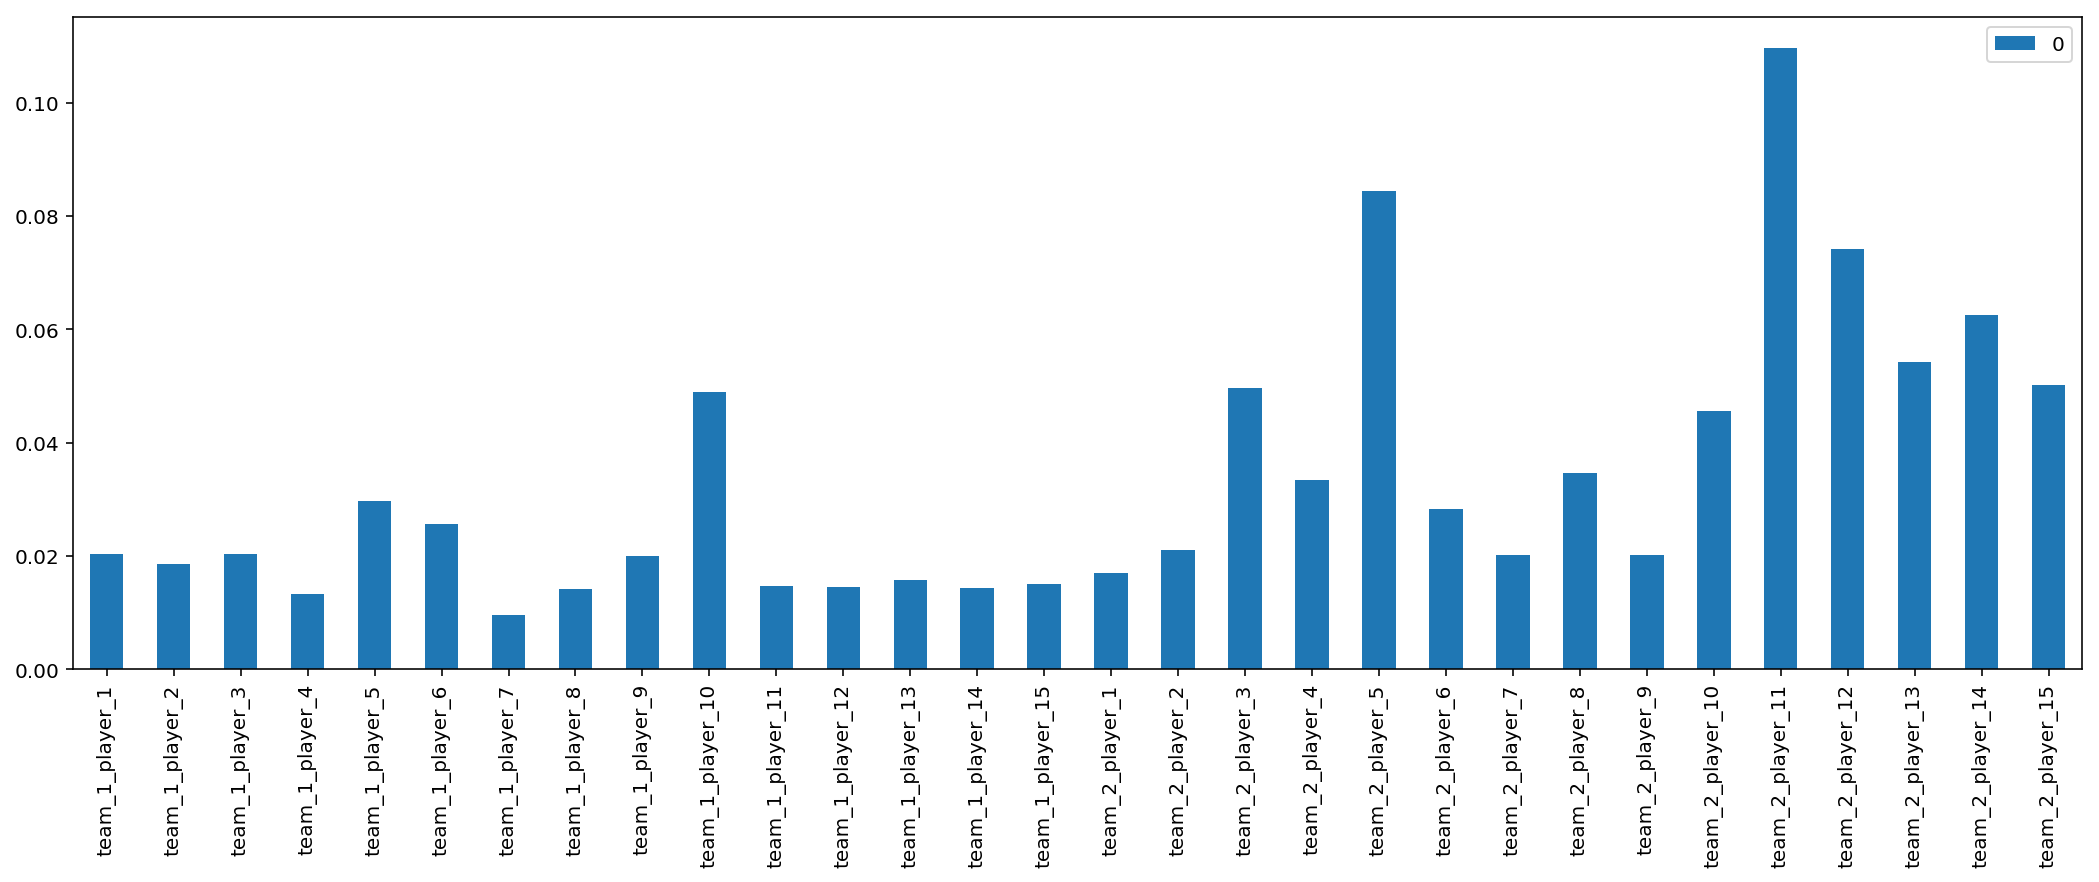

In [64]:
fig, ax = plt.subplots(figsize=(18,6))
pd.DataFrame(match_rf.feature_importances_, index=match_lineups.iloc[:,1:].columns).plot(kind="bar", ax=ax)

### 7) Strategic analysis

We will now try to do a quick strategic analysis of the matches by looking at how teams react three types of situations: 
- when the team is dominating by more than a transformed try (differential > 7)
- when the score is quite tight and no team is more than a try away than the other ( -7 < differential < 7)
- when the team is dominated by more than a transformed try (differential < 7)

In [65]:
game_events = pd.read_sql_query("""
SELECT 
    E.id,
    E.time,
    E.match_id,
    E.team_id,
    E.action_type,
    CASE E.action_type
        WHEN "tries" THEN 5
        WHEN "pens" THEN 3
        WHEN "cons" THEN 2
        WHEN "drops" THEN 3
    END as points_scored
FROM events as E
ORDER BY E.time ASC
""", conn)

In [66]:
def get_points_diferential (row):
    events_for_game = game_events.loc[game_events.loc[:,"match_id"] ==  row.loc["match_id"]]
    events_for_time = events_for_game.loc[events_for_game.loc[:,"time"] <  row.loc["time"]]
    points_scored = events_for_time.loc[events_for_time.loc[:,"team_id"] ==  row.loc["team_id"]].loc[:,"points_scored"].sum(axis = 0 )
    scored_for_other_team = events_for_time.loc[events_for_time.loc[:,"team_id"] !=  row.loc["team_id"]].loc[:,"points_scored"].sum(axis = 0 )
    return points_scored - scored_for_other_team

In [67]:
game_events["diff_before_event"] = game_events.apply(get_points_diferential, axis = 1)
game_events.describe()

,id,time,match_id,team_id,points_scored,diff_before_event
count,7923.000000,7923.000000,7923.000000,7923.000000,7923.000000,7923.000000
mean,3962.000000,40.946864,150757.959864,9.528966,3.424208,3.784678
std,2287.317424,23.323485,82740.203943,15.081501,1.209094,15.218930
min,1.000000,0.000000,22939.000000,1.000000,2.000000,-100.000000
25%,1981.500000,21.000000,93487.000000,4.000000,2.000000,-3.000000
50%,3962.000000,40.000000,153855.000000,6.000000,3.000000,2.000000
75%,5942.500000,61.000000,209465.000000,9.000000,5.000000,10.000000
max,7923.000000,80.000000,295827.000000,219.000000,5.000000,121.000000


In [68]:
def get_events_per_diff_type(df, diff_type):
    if diff_type == "under":
        return df.loc[df.loc[:,"diff_before_event"] < -7]
    elif diff_type == "tight":
        indexes_zip = zip(df.loc[:,"diff_before_event"] >= -7, df.loc[:,"diff_before_event"] <= 7)
        return df.loc[[i and j for i, j in indexes_zip]]
    elif diff_type == "over":
        return df.loc[df.loc[:,"diff_before_event"] > 7]
    
def get_action_percentage(df, action_type):
    occurence_per_action_type = df.groupby(["action_type", "time"]).size()
    total_per_time = occurence_per_action_type.groupby("time").agg("sum")
    action_per_time = occurence_per_action_type.loc[action_type]
    return action_per_time / total_per_time

def get_summary_for_action(df, action_type):
    categories = ["under", "over", "tight"]
    data = {cat: get_action_percentage(get_events_per_diff_type(df, cat), action_type) for cat in categories}
    return pd.DataFrame(data)

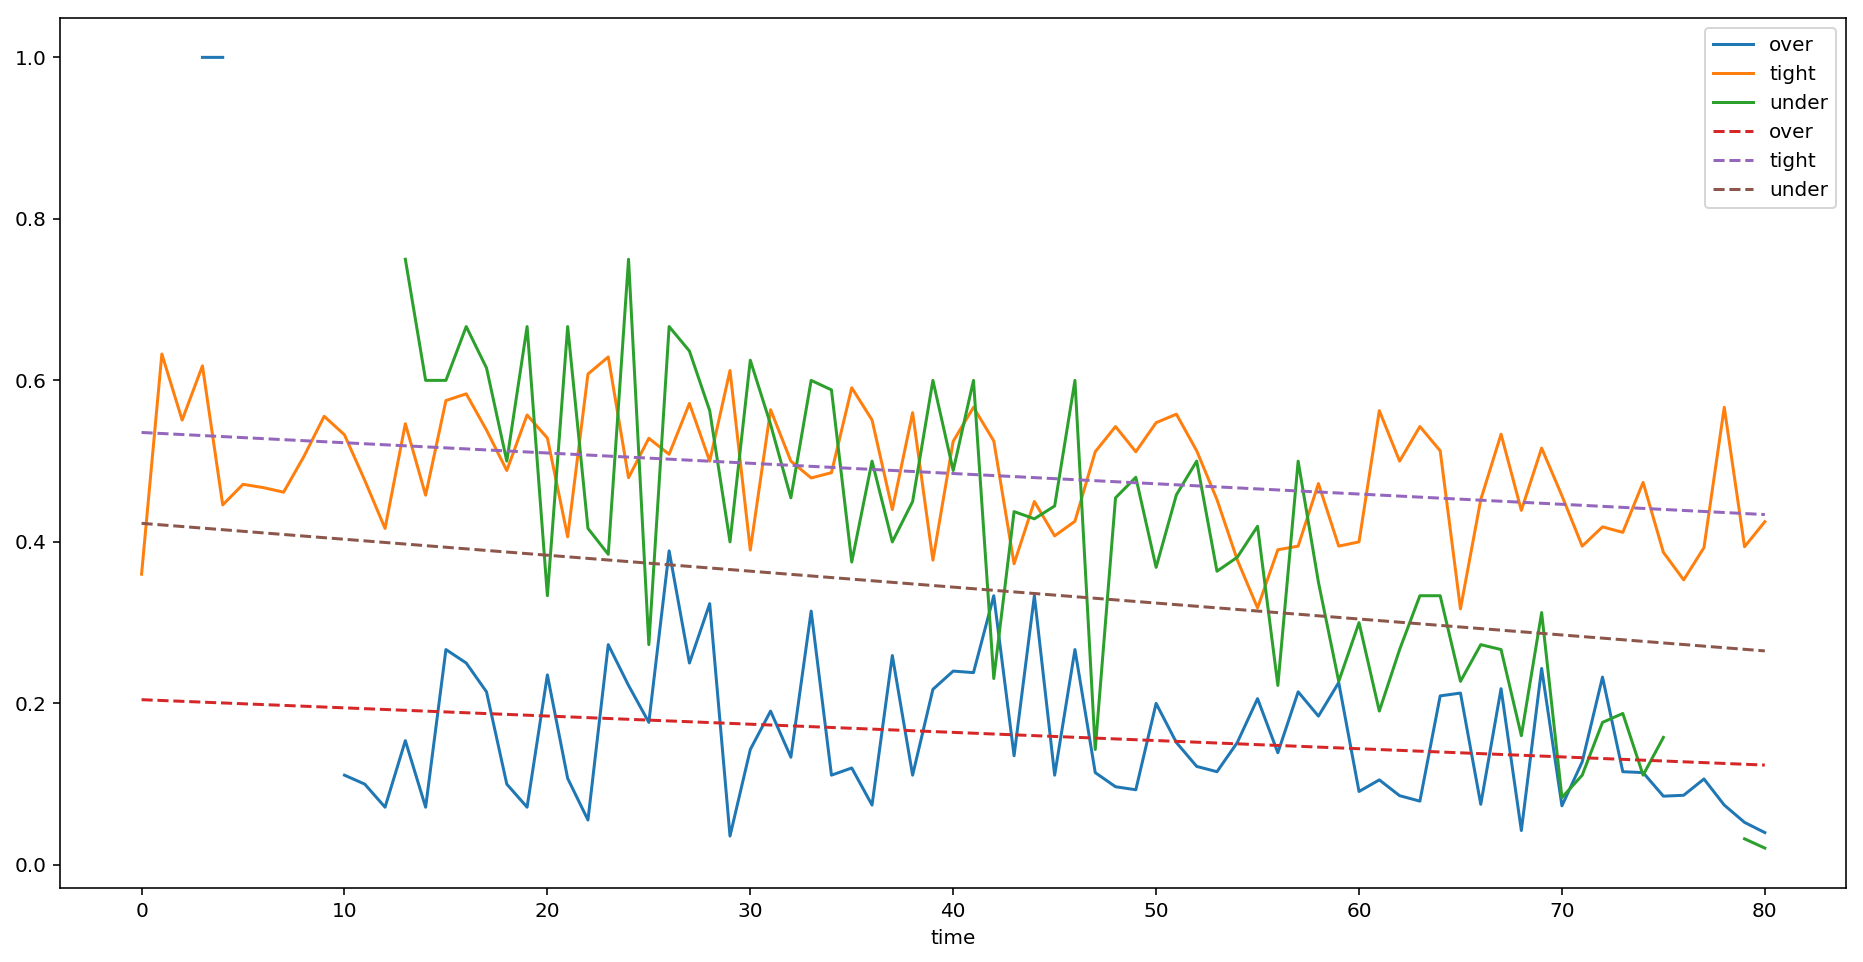

In [69]:
# Plot
from scipy.stats import linregress

def get_graph_for_action_type(df, action_type):
    data = get_summary_for_action(df, action_type)
    def get_fitted_values(column):
        indexes = column.index
        slope, intercept, r_value, p_value, std_err = linregress(indexes, column.fillna(0).tolist())
        return intercept + slope*indexes

    fig, ax = plt.subplots(figsize=(16,8))
    data.plot(ax=ax)
    data.apply(get_fitted_values, axis=0).plot(ax=ax, style='--')
    
get_graph_for_action_type(game_events, "pens")

Here we can see that the way the teams act is quite noisy, however, we can see some tendancies
- when the team is dominating, they will take few penalties as they are not runing after points, they can try to score tries to increase even more than advantage.
- when the score is tight, the teams will score as many penalties as possible as even 3 points can make a real differnece on the match.
- when the team is dominated, its response depends on the time as at the begining they will try to score some penalties: they still have some time and can try to reduce the gap by scoring.